<a href="https://colab.research.google.com/github/AmberLee2427/PopSyCLE-table/blob/main/Another_copy_of_Summer_Project_Investigating_Spitzer_Microlensing_%22Systematics%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from astropy import units as u
from astropy import coordinates as astrocoords


class Parallax:
    """Handle observatory parallax calculations.

    The class rotates observatory ephemerides into the reference frame aligned
    with a microlensing event and converts positional offsets from the time--
    impact parameter (``tau``, ``u``) system into north/east coordinates.  It
    also provides utilities for converting those coordinates back into the
    observatory frame.
    """

    def __init__(
        self,
        ra,
        dec,
        orbit,
        t_ref,
        tu=None,
        piE=None,
        epochs=None,
    ):
        """Create a parallax helper.

        Parameters
        ----------
        ra, dec : float
            Right ascension and declination of the event in degrees.
        orbit : :class:`Orbit`
            Observatory ephemeris describing the position and velocity as a
            function of time.
        t_ref : float
            Reference time in Julian days used to define the zero point of the
            parallax shift.
        tu : array_like, optional
            Precomputed parallax shift in the ``(\tau, u)`` frame.  If given it
            should be indexed by observatory name.
        piE : array_like, optional
            Microlensing parallax vector ``(\pi_{EN}, \pi_{EE})`` associated with
            ``tu``.
        epochs : dict, optional
            Dictionary mapping observatory names to the epochs of ``tu``.

        Attributes
        ----------
        ra, dec : :class:`astropy.units.Quantity`
            Coordinates of the microlensing event.
        orbit : Orbit
            Observatory ephemerides.
        tref : float
            Reference time used to centre the parallax shift.
        xref, vref : `numpy.ndarray`
            Observatory position and velocity at ``t_ref``.
        tu, ne : dict or None
            Pre-computed shifts in ``(\tau, u)`` and north/east coordinates
            indexed by observatory name when provided.

        Notes
        -----
        When ``tu`` is supplied the shift is immediately converted to north and
        east components via :meth:`tu2ne` and stored on the instance.
        """
        self.ra = ra * u.deg
        self.dec = dec * u.deg
        self.event_coords = astrocoords.SkyCoord(
            ra=self.ra, dec=self.dec, frame="icrs"
        )
        self.orbit = orbit
        self.set_ref_frame(t_ref)
        self.rotate_view()

        if tu is not None:
            self.tu = tu
            self.epochs = epochs
            ne = {}
            for obs in tu.keys():
                ne[obs] = self.tu2ne(tu[obs], piE)
                # print('observatory key:', obs)
                # print('ne', ne[obs], ne[obs].shape)
                # print('tu', tu[obs], tu[obs].shape)
            self.ne = ne
        else:
            self.tu = None
            self.ne = None

        # Event->pllx[obsidx].reset();

    # Event->pllx[obsidx].set_reference(
    #     Paramfile->simulation_zerotime + tref,
    #     &World[0].orbit,
    # )
    # Event->pllx[obsidx].set_orbit(&World[obsidx].orbit)
    # Event->pllx[obsidx].set_lb(Event->l, Event->b)
    # Event->pllx[obsidx].set_pm_lb(
    #     Lenses->data[ln][MUL] - Sources->data[sn][MUL],
    #     Lenses->data[ln][MUB] - Sources->data[sn][MUB],
    # )
    # Event->pllx[obsidx].set_piE(Event->piE)
    # Event->pllx[obsidx].set_tE_h(Event->tE_h)  # tE in the heliocentric frame

    def set_ref_frame(self, t_ref):
        """Define the reference frame for the parallax calculation.

        Parameters
        ----------
        t_ref : float
            Reference time in Julian days used to centre the parallax shift.
        """

        self.tref = t_ref  # bjd
        self.xref = self.orbit.get_pos(t_ref)
        self.vref = self.orbit.get_vel(t_ref)

    def update_piE_NE(self, piEN, piEE):
        """Set the microlensing parallax components.

        Parameters
        ----------
        piEN, piEE : float
            North and east components of the microlensing parallax vector.
        """

        self.piEN = piEN
        self.piEE = piEE

        self.piE = np.array([piEN, piEE])

    def dperp(self, t1, t2=None):
        """Return the distance perpendicular to the line of sight.

        The separation is computed between two heliocentric positions.  When a
        second epoch is not supplied the reference time ``tref`` is used.

        Parameters
        ----------
        t1 : float or array_like
            Times (JD) of the first position.
        t2 : float or array_like, optional
            Times (JD) of the second position.  If ``None`` ``self.tref`` is
            used.

        Returns
        -------
        numpy.ndarray
            Perpendicular separation in astronomical units.  A scalar is
            returned when ``t1`` and ``t2`` are single values.
        """

        pos1 = self.orbit.get_pos(t1)
        if t2 is None:
            pos2 = self.orbit.get_pos(self.tref)
        else:
            pos2 = self.orbit.get_pos(t2)

        delta = pos1 - pos2
        cross = np.cross(self.rad, delta.T).T
        return np.linalg.norm(cross, axis=0)

    def rotate_view(self):
        """Rotate observatory vectors into the event frame.

        The transformation aligns the ``z`` axis with the line of sight to the
        event such that the resulting coordinates correspond to north, east and
        the line-of-sight (``n``, ``e``, ``d``).
        """

        # unit vector pointing to the source
        self.rad = np.array(
            [
                np.cos(self.ra.to(u.rad).value)
                * np.cos(self.dec.to(u.rad).value),
                np.sin(self.ra.to(u.rad).value)
                * np.cos(self.dec.to(u.rad).value),
                np.sin(self.dec.to(u.rad).value),
            ]
        )

        # north vector in x, y, z
        north = np.array([0, 0, 1])

        # unit vector pointing east in the lens plane
        e_unit = np.cross(north, self.rad) / np.linalg.norm(
            np.cross(north, self.rad)
        )

        # unit vector pointing north in the lens plane
        n_unit = np.cross(self.rad, e_unit)

        # rotation matrix
        self.rot_matrix = np.array([n_unit, e_unit, self.rad])

        # rotate the reference values into the source pointing frame
        self.xref = np.dot(self.rot_matrix, self.xref)
        self.vref = np.dot(self.rot_matrix, self.vref)

    def counter_rotate(self, v, phi):
        """Rotate a 2-D vector by ``-phi``.

        Parameters
        ----------
        v : array_like
            Array of shape ``(N, 2)`` containing the vectors to be rotated.
        phi : float or array_like
            Angle(s) in radians for the rotation.

        Returns
        -------
        numpy.ndarray
            Rotated vectors with the same shape as ``v``.
        """

        cosp = np.cos(-phi)
        sinp = np.sin(-phi)
        return np.array(
            [v[:, 0] * cosp - v[:, 1] * sinp, v[:, 0] * sinp + v[:, 1] * cosp]
        )

    def tu2ne(self, tu, piE):
        """Convert ``(tau, u)`` shifts to north/east coordinates.

        Parameters
        ----------
        tu : array_like
            Shift in the ``(\tau, u)`` system as returned by
            :meth:`parallax_shift`.
        piE : array_like
            Microlensing parallax vector ``(\pi_{EN}, \pi_{EE})`` used to rotate
            the shift into the event frame.

        Returns
        -------
        numpy.ndarray
            Array of ``(n, e)`` offsets with the same leading dimension as
            ``tu``.
        """

        piEN = piE[0]
        piEE = piE[1]
        phi_pi = np.arctan2(piEE, piEN)
        tu_ = -tu / np.linalg.norm(piE)
        en = self.counter_rotate(tu_, phi_pi)
        # print('en', en, en.shape)
        # print('e', en[0], en[0].shape)
        ne = np.array([en[1], en[0]]).T
        return ne

    def get_pos(self, t):
        """Return the observatory position in the event frame.

        Parameters
        ----------
        t : float or array_like
            Times at which to evaluate the position expressed in Julian days.

        Returns
        -------
        numpy.ndarray
            ``(3, N)`` array of ``(n, e, d)`` coordinates in astronomical
            units.
        """

        xyz = self.orbit.get_pos(t)
        ned = np.dot(self.rot_matrix, xyz)
        return ned

    def parallax_shift(self, t, obs=None):
        r"""Calculate the parallax shift.

        Parameters
        ----------
        t : :class:`numpy.ndarray` or dict
            Times at which to evaluate the shift.  If ``t`` is a dictionary it
            should map observatory names to arrays of times.
        obs : str, optional
            Specific observatory key when ``t`` is a single array.

        Returns
        -------
        dict or :class:`numpy.ndarray`
            Parallax shift ``(dtau, dbeta)`` for each observatory or a single
            array when only one observatory is requested.

        Notes
        -----
        Gould, A., 2004, ApJ, 606, 319

        Let :math:`s(t)` be the Earth--Sun vector in units of AU in the
        heliocentric frame and evaluate

        .. math::
           \Delta s(t) = s(t) - s(t_{ref}) = (t - t_{ref})\,v_{ref}

        Observations are toward an event at some given celestial coordinates.
        Define :math:`\hat{n}` and :math:`\hat{e}` as the unit vectors pointing
        north and east such that

        .. math::
           (\Delta \tau, \Delta \beta) =
           (s_n(t)\,\pi_{EN} + s_e(t)\,\pi_{EE},
            -s_n(t)\,\pi_{EE} + s_e(t)\,\pi_{EN})
        """
        NE = {}
        tt = {}

        if (
            type(t) == np.ndarray and obs is None
        ):  # all observatories, but one t set
            keys = self.tu.keys()
            for obs in keys:
                tt[obs] = t

        elif type(t) == np.ndarray and obs is not None:  # single observatory
            tt[obs] = t
            keys = [obs]

        else:  # all observatories, all t sets
            keys = t.keys()
            tt = t  # t is a dictionary

        t = tt

        for obs in keys:
            tt = t[obs]

            NEshift = [0, 0]

            if self.tu is None:
                x = self.get_pos(
                    tt
                )  # xyz heliocentric L2 position of the observatory at time t,
                # in the ecliptic plane?
                x = np.dot(
                    self.rot_matrix, x
                )  # rotates the L2 position vector into the source-pointing
                # coordinate system

                # L2-Sun shift with n^ e^ defined when looking at the event
                NEshift[0] = (
                    x[0] - self.xref[0] - (tt - self.tref) * self.vref[0].value
                )  # array the same size as t. n^ shift component
                NEshift[1] = (
                    x[1] - self.xref[1] - (tt - self.tref) * self.vref[1].value
                )  # e^ shift component
                # I think these assume that vref (x, y) are a good enough
                # approximation for the velocity of the observatory, throughout
                # the event; i.e. the transverse velocity is assumed to be
                # constant. I'm not sure if this is a good assumption.
                # I dunno. I'm not following Andy here.
                NE[obs] = np.array(NEshift)

            else:

                ne = self.ne[obs]  # lc ne shift at lc epochs
                # print(tt.shape, self.epochs[obs].shape, ne.shape)
                NEshift[0] = np.interp(
                    tt, self.epochs[obs], ne[:, 0]
                )  # n shift at t
                NEshift[1] = np.interp(
                    tt, self.epochs[obs], ne[:, 1]
                )  # e shift at t

                NE[obs] = np.array(NEshift)

        # Michael's code (ground-based observer)
        # q_n = -S_n_arr[0] - vn0 * (ts_in - t_peak)   v is Earth's perpendicular velocity
        # q_e = -S_e_arr[0] - ve0 * (ts_in - t_peak)   I think he has north and east in the opposite direction to Matt
        # delta_tau = q_n*pi_EN + q_e*pi_EE
        # delta_beta = -q_n*pi_EE + q_e*pi_EN
        # ^ this method was introducting machine error

        # relative lens source proper motion angle in n^ e^ frame
        phi_pi = np.arctan2(self.piEE, self.piEN)

        cs = np.cos(phi_pi)
        sn = np.sin(phi_pi)

        # Convert the shift in the observer plane to a shift in the source position
        tu = {}
        for obs in NE.keys():
            tushift = [0, 0]
            tushift[0] = -np.linalg.norm(self.piE) * (
                NE[obs][0] * cs + NE[obs][1] * sn
            )  # Delta_tau - shift in the relative-motion direction
            tushift[1] = -np.linalg.norm(self.piE) * (
                -NE[obs][0] * sn + NE[obs][1] * cs
            )  # Delta_beta - shift perpendicular to the lens-source motion

            tu[obs] = tushift

        # ideally, this will cause a break if the logic is wrong
        if (
            len(tu.keys()) == 1
        ):  # unpack from the dictionary if there is only one observatory
            obs = list(tu.keys())[0]
            tu = tu[obs]

        return tu

In [3]:
# Definition of useful functions.

import numpy as np
import matplotlib.pyplot as plt

parsec = 3.086e16
lightyear = 9.461e15
AU = 1.5e11
M_sol = 2e30

def einstein_radius(ml, dl, ds):  # Returns theta_e (I believe in meters).
    g = 6.6743e-11  # Gravitational constant.
    c = 299792458  # Speed of light in m/s.
    k = 4*g/c**2
    theta_e = (np.sqrt(ml*k*((ds-dl)/(dl*ds))))
    return theta_e

def d_beta(ds, d_perp, theta_e): # in units of Einstein radius.
    del_beta = (d_perp/ds)/theta_e
    return del_beta

def impact_parameter_spitzer(u0_earth, del_beta):
    u0_spitzer = np.array([u0_earth - del_beta, u0_earth + del_beta])
    return u0_spitzer

def u_t(tau, u0):
    u_t = np.sqrt(tau**2 + u0**2)
    return u_t

def d_tau(ds, d_par, theta_e):
    del_tau = (d_par/ds)/theta_e
    return del_tau

def magnification(u):
    A = (u*u + 2)/(u*np.sqrt(u*u + 4))
    return A


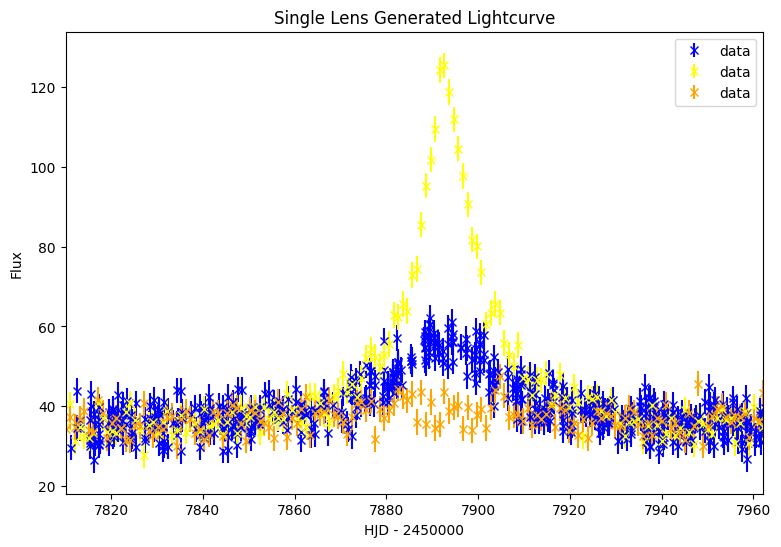

In [12]:
from typing import Tuple, Callable, Optional, List

def generate_lightcurve(
                        magnification: Callable[[np.ndarray], np.ndarray],
                        u0: float,
                        t0: float,
                        tE: float,
                        dbbinary: float,
                        dt: float,
                        FS1: float,
                        FS2: float,
                        FB: float,
                        sig: np.ndarray,
                        t: Optional[np.ndarray] = None,
                        trange: Optional[Tuple[float, float]] = None
                        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate lightcurve for given parameters and epochs or date range.

    Parameters
    ----------
    SL_magnification : Callable[[float, float, float, np.ndarray], np.ndarray]
        Single lens magnification function.
    u0 : float
        Impact parameter.
    t0 : float
        Time of closest approach.
    tE : float
        Einstein radius crossing time.
    dbbinary : float
        Binary separation.
    dt : float
        Binary separation.
    FS1 : float
        Primary source flux.
    FS2 : float
        Secondary source flux.
    FB : float
        Blend flux.
    sig : np.ndarray
        Standard deviation of Gaussian errors.
    t : Optional[np.ndarray], optional
        Array of epochs (default is None).
    trange : Optional[Tuple[float, float]], optional
        Date range (default is None).
        - tstart : float, start of date range.
        - tfinish : float, end of date range.

    Returns
    -------
    t_data : np.ndarray
        Generated time points.
    flux_data : np.ndarray
        Generated flux data with noise.
    flux_err_data : np.ndarray
        Gaussian errors.

    Raises
    ------
    ValueError
        If neither epochs nor date range is provided.
    """

    # Generate epochs if not provided
    if t is None:
        if trange is None:
            raise ValueError('Either epochs or date range must be provided.')
        tstart, tfinish = trange
        days = np.arange(np.floor(tstart), np.ceil(tfinish)) # Generate integer days within the range
        t = []
        for day in days:
            if tstart <= day <= tfinish:
                # Generate epochs for the night
                num_epochs = np.random.randint(0, 9)  # Random number of epochs between 0 and 8
                epochs = np.random.choice(np.arange(0.3, 0.6, 0.0104167), size=num_epochs, replace=False)
                t.extend(day + epochs)
    t = np.array(t)

    # Generate the trajectory
    tau = (t0 - t)/tE
    ut = u_t(tau, u0) # primary source trajectory

    u0_binary = u0 + dbbinary
    t0_binary = t0 + dt
    tau_binary = (t0_binary - t)/tE
    ut_binary = u_t(tau_binary, u0_binary)  # binary source trajectory

    # Generate theoretical flux

    A1 = magnification(ut)
    A2 = magnification(ut_binary)

    flux_theoretical = A1*FS1 + A2*FS2 + FB

    # Generate Gaussian noise
    noise = np.random.normal(0, sig, size=t.shape)

    # Generate noisy flux data
    flux_data = flux_theoretical + noise

    # Gaussian errors
    flux_err_data = np.full(t.shape, sig)

    return t, flux_data, flux_err_data


# making up event parameters and data stats
sig = 3.2  # figure out good numbers for this
u0 = 0.4321
t0 = 7892.123
tE = 23.4
dbbinary = 0.5
dt = 0.5
FS1 = 10.0
FS2 = 15.0
FB = 10.0

trange = (t0-82, t0+70)

# generating fake Earth data
t_data, flux_data, flux_err_data = generate_lightcurve(magnification, u0, t0, tE, dbbinary, dt, FS1, FS2, FB, sig, trange=trange)

# generate fake Spitzer data
sig_spitzer = 10.5  # get a real number for this
FS1 = 10.0
FS2 = 15.0
FB = 10.0
t_spitzer_data = np.linspace(trange[0], trange[1], int(trange[1]-trange[0]))  # once per day
db = d_beta(8500*parsec, 1*AU, einstein_radius(0.2*M_sol, 7000*parsec, 8500*parsec))
dt = d_tau(8500*parsec, 1*AU, einstein_radius(0.2*M_sol, 7000*parsec, 8500*parsec))
u0_spitzer_1, u0_spitzer_2 = impact_parameter_spitzer(u0, db)
t0_spitzer = t0 + dt*tE
t_spitzer, flux_spitzer1, flux_err_spitzer1 = generate_lightcurve(
    magnification,
    u0_spitzer_1,
    t0_spitzer,
    tE,
    dbbinary,
    dt,
    FS1,
    FS2,
    FB,
    sig,
    t = t_spitzer_data
)
t_spitzer, flux_spitzer2, flux_err_spitzer2 = generate_lightcurve(
    magnification,
    u0_spitzer_2,
    t0_spitzer,
    tE,
    dbbinary,
    dt,
    FS1,
    FS2,
    FB,
    sig,
    t = t_spitzer_data
)


# Let's start by taking a look at the data
plt.close(1)
plt.figure(figsize=(9,6), num=1)
plt.errorbar(t_data, flux_data, yerr=flux_err_data, fmt='x', color='blue', label='data')
plt.errorbar(t_spitzer, flux_spitzer1, yerr=flux_err_spitzer1, fmt='x', color='yellow', label='data')
plt.errorbar(t_spitzer, flux_spitzer2, yerr=flux_err_spitzer2, fmt='x', color='orange', label='data')
plt.xlabel('HJD - 2450000')
plt.ylabel('Flux')
plt.title('Single Lens Generated Lightcurve')
plt.xlim(trange[0], trange[1])
#plt.xlim(t0-2, t0+2)
plt.legend()
plt.show()

In [23]:
def binary_timeshift(d_binary, ds, phi_binary, er):
  """
  Calcuate the difference in peak times between the primary and secondary sources.

  Inputs
  ------
  d_binary: distance between the two sources in AU
  ds: distance to the primary source in parsecs
  phi_binary: angle of binary separation in degrees
  er: Einstein radius in meters

  Returns
  -------
  dt_binary: difference in peak times in seconds
  """
  beta_binary = (d_binary/ds)/er
  dt_binary = beta_binary*np.cos(phi_binary)

  return dt_binary

In [13]:
!pip install MulensModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 2.3 MB/s eta 0:00:00


In [18]:
import MulensModel as mm

finite_source_methods = [
    # Uniform source
    'finite_source_uniform_Gould94',               # 0, 10E-3 < rho < 1 (has a bug)
    'finite_source_uniform_Gould94_direct',        # 1, 10E-3 < rho < 1
    'finite_source_uniform_WittMao94',             # 2, rho < 0.01
    'finite_source_uniform_Lee09',                 # 3, rho > 0.01

    # Limb-darkened source
    'finite_source_LD_WittMao94',                  # 4, rho < 0.01
    'finite_source_LD_Yoo04',                      # 5, 10E-3 < rho < 1
    'finite_source_LD_Yoo04_direct',               # 6, 10E-3 < rho < 1
    'finite_source_LD_Lee09'                       # 7, rho > 0.01
]

# objective function
def binary_source_chi2(theta: np.ndarray,
                       model1: mm.Model,
                       model2: mm.Model,
                       data: List,
                       verbose: Optional[bool] = False,
                       return_fluxes: Optional[bool] = False
                       ) -> float:
    """
    chi2 function for a binary-source, single-lens, microlensing model.

    Parameters
    ----------
    theta : np.ndarray
        Array of model parameters being fit.
    model1 : mm.Model
        Primary source model.
    model2 : mm.Model
        Secondary source model.
    data : list
        List of data arrays.
    verbose : bool, optional
        Default is False.
        Print the primary source flux, secondary source flux, and blend flux.

    Returns
    -------
    float
        The chi2 value.

    Notes
    -----
    The model parameters are unpacked from theta and set to the model1 and model2 parameters.
    model1 and model2 are MulensModel.Model objects; see MulensModel documentation
    (https://rpoleski.github.io/MulensModel/) for more information.
    """
    #unpack the data
    t, flux, flux_err = data

    # model parameters being fit
    labels = ['t_0', 'u_0', 't_E']

    # change the values of model.parameters to those in theta.
    theta1 = theta[:3]
    theta2 = theta[3:]
    for (label, value1, value2) in zip(labels, theta1, theta2):
        setattr(model1.parameters, label, value1)
        setattr(model2.parameters, label, value2)

    # calculate the model magnification for each source
    A1 = model1.get_magnification(t)
    A2 = model2.get_magnification(t)

    ######################
    # EXERCISE: BinarySourceE1.txt
    #----------------------
    # build the matricies for the linear algebra
    C = np.array([np.sum(A1 * flux * flux_err**-2), np.sum(A2 * flux * flux_err**-2), np.sum(flux * flux_err**-2)])
    B = np.array([[np.sum(A1**2 * flux_err**-2), np.sum(A1 * A2 * flux_err**-2), np.sum(A1 * flux_err**-2)],
                  [np.sum(A1 * A2 * flux_err**-2), np.sum(A2**2 * flux_err**-2), np.sum(A2 * flux_err**-2)],
                  [np.sum(A1 * flux_err**-2), np.sum(A2 * flux_err**-2), np.sum(flux_err**-2)]])

    # calculate the flux components
    Theta = np.linalg.solve(B, C)  # ax=b <- B x Theta = C
    FS1, FS2, FB = Theta # primary source flux, secondary source flux, and blend flux
    ######################

    # print the flux parameters
    if verbose:
        print(f"Primary source flux: {FS1}")
        print(f"Secondary source flux: {FS2}")
        print(f"Blend flux: {FB}")

    # calculate the model flux
    model_flux = A1 * FS1 + A2 * FS2 + FB
    chi2 = np.sum(((flux - model_flux) / flux_err)**2)

    # In case something goes wrong with the linear algebra
    if np.isnan(chi2) or np.isinf(chi2):
        print(f"NaN or inf encountered in chi2 calculation: theta={theta}, chi2={chi2}")
        return 1e16

    if return_fluxes:
        return chi2, FS1, FS2, FB
    else:
        return chi2

In [21]:
theta = np.array([t0, u0, tE, t0_spitzer, u0_spitzer_1, tE])

earth_data = [t_data, flux_data, flux_err_data]

# MulensModel Objects
pspl_primary = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE})
pspl_secondary = mm.Model({'t_0': t0_spitzer, 'u_0': u0_spitzer_1, 't_E': tE})

# initial chi2 value (will print the fluxes)
chi2 = binary_source_chi2(theta, pspl_primary, pspl_secondary, earth_data, verbose=True)

print(f"chi^2 = {chi2}")
print(f"n = {len(t_data)}")
print(f"ndof = {len(t_data) - len(theta)}")
print(f"reduced chi^2 = {chi2 / (len(t_data) - len(theta))}")

Primary source flux: 17.00308214548717
Secondary source flux: -0.8124210487653174
Blend flux: 19.177997722667207
chi^2 = 707.2229814370173
n = 608
ndof = 602
reduced chi^2 = 1.174789005709331


In [ ]:
def fit_binary_source()

In [25]:
from scipy.optimize import minimize

def flat_line_fit(data):
  """
  """
  t, flux, flux_err = data
  chi2_initial = chi2_flat(np.mean(flux))

  def chi2_flat(F):
    """
    """
    chi2 = np.sum(((flux - F) / flux_err)**2)

    return chi2

  # Minimize using Nelder-Mead
  result = minimize(chi2_flat, np.mean(flux), method='Nelder-Mead')

  # Calculate best chi2
  F_best = result.x[0]
  chi2 = chi2_flat(F_best)

  return chi2

In [27]:
def single_source_fit(data, theta0):
  """
  """
  t, flux, flux_err = data
  chi2_initial = chi2_single(theta0)

  def chi2_single(u0, t0, tE, FS, FB):
    """
    """
    tau = (t0-t)/tE
    ut = u_t(tau, u0)
    A = magnification(ut)
    F = FS*A + FB
    chi2 = np.sum(((flux - F) / flux_err)**2)

    return chi2

  # Minimize using Nelder-Mead
  result = minimize(chi2_single, theta0, method='Nelder-Mead')

  # Calculate best chi2
  u0_best, t0_best, tE_best, FS_best, FB_best = result.x
  chi2 = chi2_single(u0_best, t0_best, tE_best, FS_best, FB_best)

  return chi2

In [26]:
# remake spitzer_detectable with fits
import numpy as np
import matplotlib.pyplot as plt
import math

def Spitzer_lc_detectable(
    ml, dl, ds, u0_earth, phi, phi_binary, d_binary,
    tE,
    FS1_I, FS2_I, FB_I,
    FS1_L, FS2_L, FB_L
    ):

    """

    Tags a cell Spitzer-only detectable if a source is only microlensed as seen
    from Spitzer.

    Inputs:
    ml: mass of the lens in solar masses
    ds: distance to the primary source in parsecs
    dl: distance to the lens in parsecs
    u0_earth: u0 of the event as seen from Earth in units of Einstein radius
    phi: angle between Earth and Spitzer in degrees
    phi_binary: angle of binary separation in degrees
    d_binary: distance between the two sources in AU
    tE: Einstein radius crossing time (days)
    FS1_I: flux of the primary source seen from Earth
    FS2_I: flux of the secondary source seen from Earth
    FB_I: flux of the blend seen from Earth
    FS1_L: flux of the primary source seen from Spitzer
    FS2_L: flux of the secondary source seen from Spitzer
    FB_L: flux of the blend seen from Spitzer

    Returns whether or not the secondary source appears lensed from Spitzer only.

    """
    t0 = 0.0
    parsec = 3.086e16
    lightyear = 9.461e15
    AU = 1.5e11
    M_sol = 2e30

    # unit conversions to SI units.
    ml = ml*M_sol #converts to kg
    ds = ds*parsec #converts to m
    dl = dl*parsec
    d_binary = d_binary*AU #converts to m

    g = 6.6743e-11  # Gravitational constant.
    c = 299792458  # Speed of light in m/s.
    k = 4*g/(c**2)

    phi_binary = phi_binary * np.pi / 180 #converts to radians
    phi = phi * np.pi / 180

    er = np.sqrt(ml*k*((ds-dl)/(dl*ds))) # in meters...

    d_perp = np.sin(phi) *1*AU

    #d_par = np.cos(phi) *1.*AU

    db = (d_perp/ds)/er
    u0_spitzer = u0_earth + db

    beta_binary = (d_binary/ds)/er
    db_binary = beta_binary*np.sin(phi_binary)
    #print(db_binary)

    u0_earth_s1 = u0_earth
    u0_earth_s2 = u0_earth_s1 + db_binary
    u0_spitzer_s1 = u0_earth + db
    u0_spitzer_s2 = u0_spitzer_s1 + db_binary

    # Calculate t0
    db = d_beta(ds*parsec, d_binary*AU, er)
    dt = d_tau(ds*parsec, d_binary*AU, er)*tE
    t0_spitzer = t0 + dt

    t02_earth = 0.0 + binary_timeshift(d_binary, ds, phi_binary, er)
    t02_spitzer = t0_spitzer + binary_timeshift(d_binary, ds, phi_binary, er)

    # Generate the data
    trange = (-75.0, 75.0)
    sig_I = 10.5 # get a better number for this
    earth_data = generate_lightcurve(
        magnification,
        u0,
        0.0,
        tE,
        dbbinary,
        dt,
        FS1_I,
        FS2_I,
        FB_I,
        sig_I,
        trange=trange
    )
    spitzer_data = generate_lightcurve(
        magnification,
        u0_spitzer_s1,
        t0_spitzer,
        tE,
        dbbinary,
        dt,
        FS1_L,
        FS2_L,
        FB_L,
        sig_I,
        trange=trange
    )

    # MulensModels
    pspl_earth = mm.Model({'t_0': 0.0, 'u_0': u0_earth_s1, 't_E': tE})
    pspl_spitzer1 = mm.Model({'t_0': t0_spitzer, 'u_0': u0_spitzer_s1, 't_E': tE})
    pspl_earth_binary = mm.Model({'t_0': t02_earth, 'u_0': u0_earth_s2, 't_E': tE})
    pspl_spitzer1_binary = mm.Model({'t_0': t02_spitzer, 'u_0': u0_spitzer_s2, 't_E': tE})

    # Detactability criteria of Deltachi2>500
    chi2_earth_flat = flat_line_fit(earth_data)
    chi2_spitzer_flat = flat_line_fit(spitzer_data)

    theta_earth = np.array([0.0, u0_earth_s1, tE, t02_earth, u0_earth_s2, tE])
    theta_spitzer1 = np.array([t0_spitzer, u0_spitzer_s1, tE, t02_spitzer, u0_spitzer_s2, tE])
    chi2_earth_binary = binary_source_chi2(theta_earth, pspl_earth, pspl_earth_binary, earth_data, verbose=False)
    chi2_spitzer_binary1 = binary_source_chi2(theta_spitzer1, pspl_spitzer1, pspl_spitzer1_binary, spitzer_data, verbose=False)

    theta_earth1 = np.array([u0_earth_s1, 0.0, tE, FS1_I, FB_I + FS2_I])
    theta_earth2 = np.array([u0_earth_s2, t02_earth, tE, FS2_L, FB_L + FS1_L])
    chi2_earth_single1 = single_source_fit(earth_data, theta_earth1)
    chi2_earth_single2 = single_source_fit(earth_data, theta_earth2)

    theta_spitzer1 = np.array([u0_spitzer_s1, t0_spitzer, tE, FS1_L, FB_L + FS2_L])
    theta_spitzer2 = np.array([u0_spitzer_s2, t02_spitzer, tE, FS2_I, FB_I + FS1_I])
    chi2_spitzer_single1 = single_source_fit(spitzer_data, theta_spitzer1)
    chi2_spitzer_single2 = single_source_fit(spitzer_data, theta_spitzer2)


    is_Spitzer_only_detectable = np.zeros((len(u0_earth_s1), 5))

    #is_Spitzer_only_detectable = (np.where(np.abs(u0_earth_s1) < 1, "a", "b") +
    #                              np.where(np.abs(u0_spitzer_s1) < 1, "c", "d") +
    #                              np.where(np.abs(u0_earth_s2) >= 1, "e", "f") +
    #                              np.where(np.abs(u0_spitzer_s2) < 1, "g", "h"))
    # not detectable for earth = "i"

    # check for solution swapping

    for i in range(len(u0_earth_s1)):
        if (chi2_earth_flat[i] - chi2_earth_binary) > 500:
            is_Spitzer_only_detectable[i][0] = 1

            if (chi2_earth_single1 - chi2_earth_binary) < 160:
                is_Spitzer_only_detectable[i][1] = 1
                is_Spitzer_only_detectable[i][2] = 0
            elif (chi2_earth_single2 - chi2_earth_binary) < 160:
                is_Spitzer_only_detectable[i][1] = 0
                is_Spitzer_only_detectable[i][2] = 1
            else:
                is_Spitzer_only_detectable[i][1] = 1
                is_Spitzer_only_detectable[i][2] = 1

            if (chi2_spitzer_single1 - chi2_spitzer_binary1) < 160:
                is_Spitzer_only_detectable[i][3] = 1
                is_Spitzer_only_detectable[i][4] = 0
            if (chi2_spitzer_single2 - chi2_spitzer_binary1) < 160:
                is_Spitzer_only_detectable[i][3] = 0
                is_Spitzer_only_detectable[i][4] = 1
            else:
                is_Spitzer_only_detectable[i][3] = 1
                is_Spitzer_only_detectable[i][4] = 1

    letters = np.zeros_like(u0_earth_s1)
    for i in range(len(u0_earth_s1)):
        if is_Spitzer_only_detectable[i][1] == 1:
            letters[i] = "a"
        else:
            letters[i] = "b"
        if is_Spitzer_only_detectable[i][2] == 1:
            letters[i] += "c"
        else:
            letters[i] += "d"
        if is_Spitzer_only_detectable[i][3] == 0:
            letters[i] += "e"
        else:
            letters[i] += "f"
        if is_Spitzer_only_detectable[i][4] == 1:
            letters[i] += "g"
        else:
            letters[i] += "h"

    print(letters)

    return letters #Spitzer_detectable_index

isod = Spitzer_lc_detectable(1, 3000, np.array([5000,6000,7000,8000])[3], 0.1, 90, 90, 1)
print(isod)

# Key:
# aceg (blue) = S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.
# adfh (red) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.
# adeh (green) = S1 detectable from Earth but not Spitzer, S2 not detectable.
# adfg (yellow) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.
# adeg (magenta) = S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.
# acfh (cyan) = S1 detectable from Earth and Spitzer, S2 detectable from Earth only.
# aceh (orange) = S1 detectable from Earth and Spitzer, S2 not detectable.
# acfg (purple) = S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer.

# These are irrelevant, right? I'm putting them in the dictionary anyway just in case.
# bdfh = S1 not detectable from earth or Spitzer, S2 detectable from earth only.
# bdeh = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bdfg = S1 not detectable from earth or Spitzer, S2 detectable from Earth and Spitzer.
# bdeg = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bcfh = S1 not detectable from earth but detectable from Spitzer, S2 detectable from earth only.
# bceh = S1 not detectable from earth but detectable from Spitzer, S2 not detectable.
# bceg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Spitzer only.
# bcfg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Earth and Spitzer.


#n = 1 # number of samples you want

#Ds = np.sqrt(np.random.uniform(500**2, 8500**2, n)) # in parsecs
#Dl = np.sqrt(np.random.uniform(2000**2, 5000**2, n)) # also in parsecs
#dbinary_array = np.log(np.random.lognormal(40, 1.5, n)) # in AU
#u0_array = np.linspace(-1, 1, 201) # units of einstein radius
#phi_array = np.linspace(0, 180, 181)

#sd = Spitzer_detectable(1.*M_sol, Dl, Ds, u0_array, phi_array, -90, dbinary_array*AU)
#print(sd)

SyntaxError: invalid syntax (ipython-input-2039502206.py, line 2)

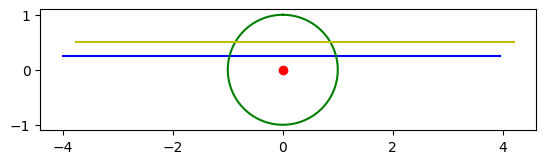

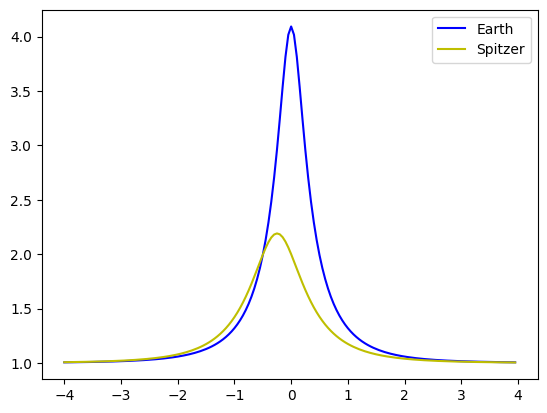

In [16]:
# Plotting magnification and trajectory as seen from Earth and Spitzer using the equations defined above.

ds = 1000*parsec # Converts to meters to plug into function.
dl = 500*parsec
er = einstein_radius(1.*M_sol, dl, ds)
phi = 45 * np.pi / 180 # degrees converted to radians.
d_perp = 1*AU * np.sin(phi) # AU converted to meters.
d_par = 1*AU * np.cos(phi)
u0_earth = 0.25 # theta_E
tau_e = np.arange(-4, 4, 0.05)  # tau (parallel to trajectory) from earth
ut_earth = u_t(tau_e, u0_earth)
tau_ex = tau_e
tau_ey = np.ones_like(tau_e) * u0_earth
circle = np.linspace(0, 2*np.pi, 360)
circle_x = np.sin(circle)
circle_y = np.cos(circle)

db = d_beta(ds, d_perp, er)
dt = d_tau(ds, d_par, er)
tau_spitzer = tau_e + dt

u0_spitzer = u0_earth + db
ut_spitzer = u_t(tau_spitzer, u0_spitzer)

tau_spitzerx = tau_spitzer
tau_spitzery = np.ones_like(tau_spitzer) * u0_spitzer


plt.plot(tau_ex, tau_ey, c="b", label='Earth')
plt.scatter(0,0, c = "r", label='lens')
plt.plot(circle_x, circle_y, c="g", label='Einstein ring')
plt.gca().set_aspect('equal')
plt.plot(tau_spitzerx, tau_spitzery, c="y", label='Spitzer')
#plt.legend()
plt.show()

A_earth = magnification(ut_earth)
A_spitzer = magnification(ut_spitzer)
plt.plot(tau_e, A_earth, c='b', label='Earth')
plt.plot(tau_spitzer-dt, A_spitzer, c='y', label='Spitzer')
plt.legend()
plt.show()

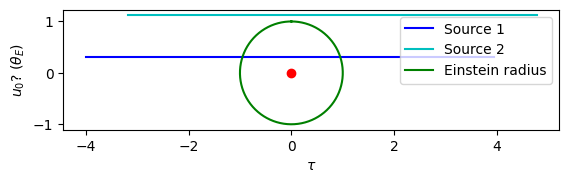

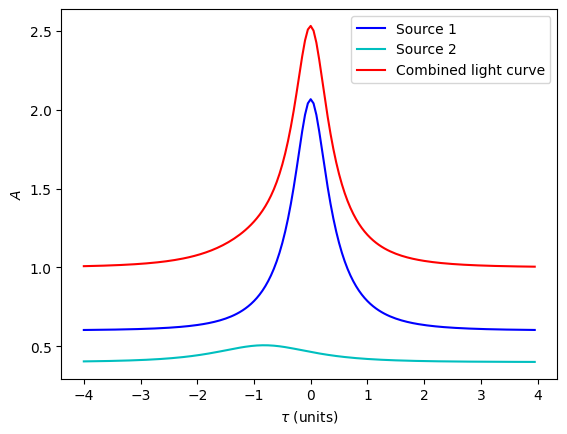

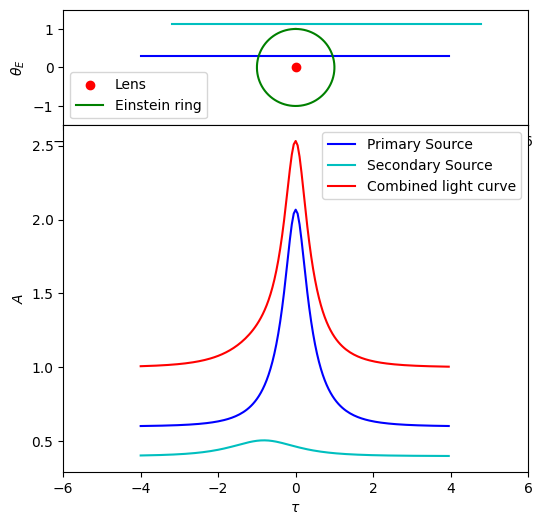

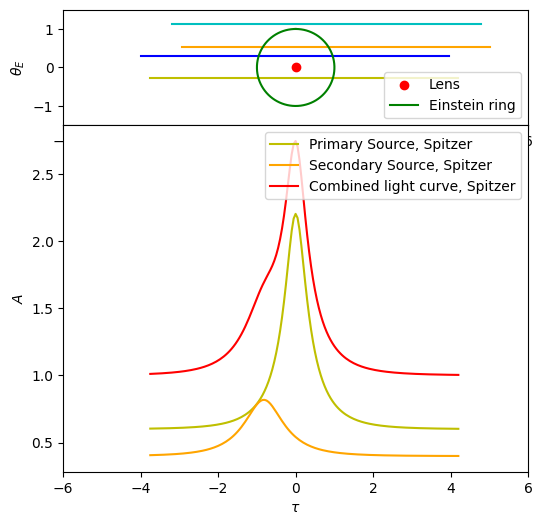

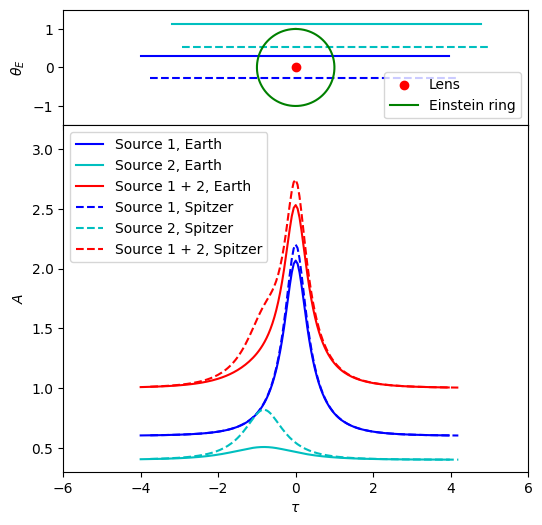

In [ ]:
# Plotting trajectory and magnification for both the primary and secondary sources as seen from both Earth and Spitzer; similar to above.

ds = 8500*parsec
dl = 7000*parsec
er = einstein_radius(0.2*M_sol, dl, ds) #ml in solar masses but converted to kg.
phi = -90 * np.pi / 180
d_perp = 1.*AU * np.sin(phi)
d_par = 1.*AU * np.cos(phi)
circle = np.linspace(0, 2*np.pi, 360)
circle_x = np.sin(circle)
circle_y = np.cos(circle)

db = d_beta(ds, d_perp, er)
dt = d_tau(ds, d_par, er)

phi_binary = 45 * np.pi / 180
d_binary = 2*AU
beta_binary = (d_binary/ds)/er
dt_binary = beta_binary*np.cos(phi_binary)
db_binary = beta_binary*np.sin(phi_binary)

u0_earth_s1 = 0.3 #u0_earth
tau_e_s1 = np.arange(-4, 4, 0.05)
ut_earth_s1 = u_t(tau_e_s1, u0_earth_s1)
tau_ex_s1 = tau_e_s1
tau_ey_s1 = np.ones_like(tau_e_s1) * u0_earth_s1

u0_earth_s2 = u0_earth_s1 + db_binary
tau_e_s2 = tau_e_s1 #+ dt_binary
ut_earth_s2 = u_t(tau_e_s2 + dt_binary, u0_earth_s2)
tau_ex_s2 = tau_e_s2 + dt_binary
tau_ey_s2 = np.ones_like(tau_e_s2) * u0_earth_s2

u0_spitzer_s1 = u0_earth_s1 + db
tau_spitzer_s1 = tau_spitzer
ut_spitzer_s1 = u_t(tau_spitzer_s1, u0_spitzer_s1)
tau_spitzerx_s1 = tau_spitzer_s1
tau_spitzery_s1 = np.ones_like(tau_spitzer_s1) * u0_spitzer_s1

u0_spitzer_s2 = u0_spitzer_s1 + db_binary
tau_spitzer_s2 = tau_spitzer_s1 + dt_binary
ut_spitzer_s2 = u_t(tau_spitzer_s2, u0_spitzer_s2)
tau_spitzerx_s2 = tau_spitzer_s2
tau_spitzery_s2 = np.ones_like(tau_spitzer_s2) * u0_spitzer_s2

plt.plot(tau_ex_s1, tau_ey_s1, c="b", label="Source 1")
plt.plot(tau_ex_s2, tau_ey_s2, c="c", label="Source 2")
#plt.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
#plt.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
plt.scatter(0, 0, c = "r")
plt.plot(circle_x, circle_y, c="g", label= "Einstein radius")
plt.gca().set_aspect('equal')
plt.xlabel('$τ$')
plt.ylabel('$u_0$? ($θ_E$)')
plt.legend()
plt.savefig("background_explanation1.png")
plt.show()


A_earth_s1 = magnification(ut_earth_s1)
A_earth_s2 = magnification(ut_earth_s2)
A_earth_binary = 0.6*A_earth_s1 + 0.4*A_earth_s2
A_spitzer_s1 = magnification(ut_spitzer_s1)
A_spitzer_s2 = magnification(ut_spitzer_s2)
A_spitzer_binary = 0.6*A_spitzer_s1 + 0.4*A_spitzer_s2
plt.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Source 1")
plt.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Source 2")
plt.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve")
plt.xlabel('$τ$ (units)')
plt.ylabel('$A$')
#plt.plot(tau_spitzer_s1-dt, A_spitzer_s1, c="y")
#plt.plot(tau_spitzer_s2-dt, A_spitzer_s2, c="orange")
plt.legend()
plt.savefig("background_explanation2.png")
plt.show()
# Mark binaries, angles, lines between. Make plot that explains angles.

fig = plt.figure(1, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
#ax1.gca().set_aspect('equal')
#ax1.set_xlabel('$τ$')
ax1.set_ylabel('$θ_E$')
#plt.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Primary Source")
ax2.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Secondary Source")
ax2.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6, 6)

ax1.legend()
ax2.legend()
plt.subplots_adjust(wspace=0, hspace=0)
 # How do I make it show the legend for the top plot too?
plt.savefig("example_curves_earth.png")
plt.show()

fig = plt.figure(2, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
ax1.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
ax1.set_ylabel('$θ_E$')
ax1.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_spitzer_s1, 0.6*A_spitzer_s1, c="y", label="Primary Source, Spitzer")
ax2.plot(tau_spitzer_s2-dt_binary, 0.4*A_spitzer_s2, c="orange", label="Secondary Source, Spitzer")
ax2.plot(tau_spitzer_s1, A_spitzer_binary, c="r", label="Combined light curve, Spitzer")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6,6)

ax1.legend(loc="lower right")
ax2.legend()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("example_curves_spitzer.png")
plt.show()

# Plotting the view from Earth and Spitzer at the same time for illustrating parameters.
fig = plt.figure(2, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.plot(tau_spitzerx_s1, tau_spitzery_s1, c="b", linestyle="--")
ax1.plot(tau_spitzerx_s2, tau_spitzery_s2, c="c", linestyle="--")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
ax1.set_xticklabels('')
ax1.set_ylabel('$θ_E$')
ax1.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Source 1, Earth")
ax2.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Source 2, Earth")
ax2.plot(tau_e_s1, A_earth_binary, c="r", label="Source 1 + 2, Earth")
ax2.plot(tau_spitzer_s1, 0.6*A_spitzer_s1, c="b", linestyle="--", label="Source 1, Spitzer")
ax2.plot(tau_spitzer_s2-dt_binary, 0.4*A_spitzer_s2, c="c", linestyle="--", label="Source 2, Spitzer")
ax2.plot(tau_spitzer_s1, A_spitzer_binary, c="r", linestyle="--", label="Source 1 + 2, Spitzer")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6,6)
ax2.set_ylim(0.3, 3.2)

ax1.legend(loc="lower right")
ax2.legend(loc="upper left")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("example_curves_both.png", bbox_inches='tight')
plt.show()


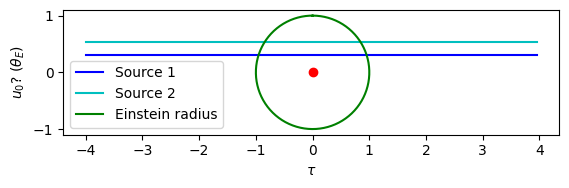

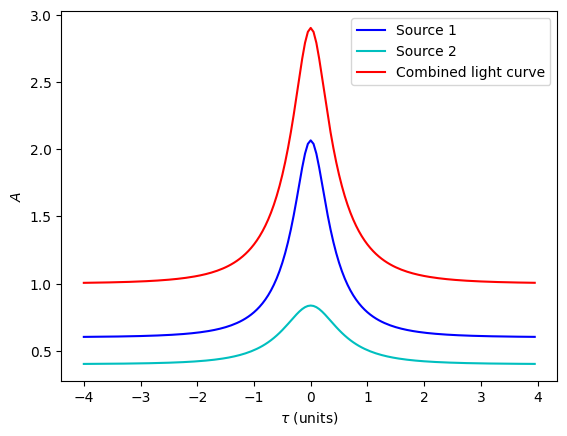

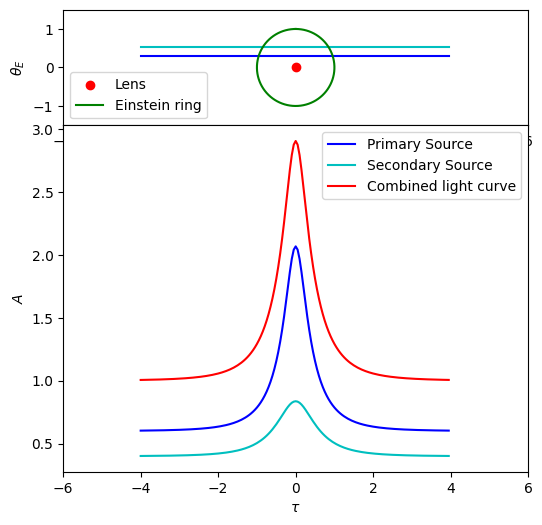

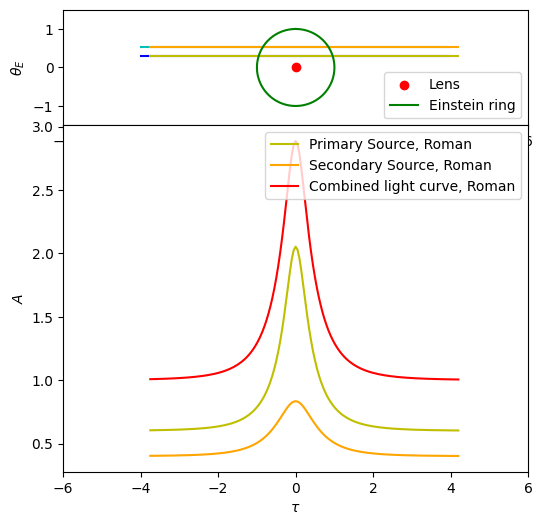

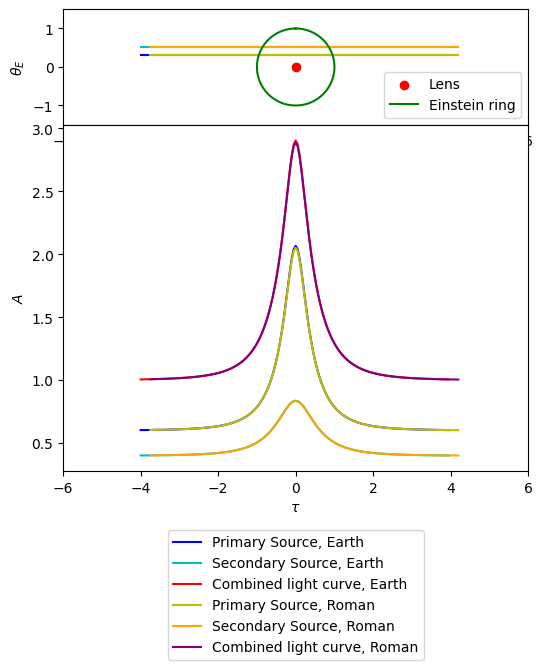

In [ ]:
"""
ROMAN NUMBERS
"""

# Plotting trajectory and magnification for both the primary and secondary sources as seen from both Earth and ROMAN; similar to above.

ds = 8000*parsec
dl = 2000*parsec
er = einstein_radius(0.1*M_sol, dl, ds) #ml in solar masses but converted to kg.
phi = 90 * np.pi / 180
d_perp = 0.01*AU * np.sin(phi)
d_par = 0.01*AU * np.cos(phi)
circle = np.linspace(0, 2*np.pi, 360)
circle_x = np.sin(circle)
circle_y = np.cos(circle)

db = d_beta(ds, d_perp, er)
dt = d_tau(ds, d_par, er)

phi_binary = 90 * np.pi / 180
d_binary = 1*AU
beta_binary = (d_binary/ds)/er
dt_binary = beta_binary*np.cos(phi_binary)
db_binary = beta_binary*np.sin(phi_binary)

u0_earth_s1 = 0.3 #u0_earth
tau_e_s1 = np.arange(-4, 4, 0.05)
ut_earth_s1 = u_t(tau_e_s1, u0_earth_s1)
tau_ex_s1 = tau_e_s1
tau_ey_s1 = np.ones_like(tau_e_s1) * u0_earth_s1

u0_earth_s2 = u0_earth_s1 + db_binary
tau_e_s2 = tau_e_s1 #+ dt_binary
ut_earth_s2 = u_t(tau_e_s2 + dt_binary, u0_earth_s2)
tau_ex_s2 = tau_e_s2 + dt_binary
tau_ey_s2 = np.ones_like(tau_e_s2) * u0_earth_s2

u0_spitzer_s1 = u0_earth_s1 + db
tau_spitzer_s1 = tau_spitzer
ut_spitzer_s1 = u_t(tau_spitzer_s1, u0_spitzer_s1)
tau_spitzerx_s1 = tau_spitzer_s1
tau_spitzery_s1 = np.ones_like(tau_spitzer_s1) * u0_spitzer_s1

u0_spitzer_s2 = u0_spitzer_s1 + db_binary
tau_spitzer_s2 = tau_spitzer_s1 + dt_binary
ut_spitzer_s2 = u_t(tau_spitzer_s2, u0_spitzer_s2)
tau_spitzerx_s2 = tau_spitzer_s2
tau_spitzery_s2 = np.ones_like(tau_spitzer_s2) * u0_spitzer_s2

plt.plot(tau_ex_s1, tau_ey_s1, c="b", label="Source 1")
plt.plot(tau_ex_s2, tau_ey_s2, c="c", label="Source 2")
#plt.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
#plt.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
plt.scatter(0, 0, c = "r")
plt.plot(circle_x, circle_y, c="g", label= "Einstein radius")
plt.gca().set_aspect('equal')
plt.xlabel('$τ$')
plt.ylabel('$u_0$? ($θ_E$)')
plt.legend()
plt.savefig("background_explanation1.png")
plt.show()


A_earth_s1 = magnification(ut_earth_s1)
A_earth_s2 = magnification(ut_earth_s2)
A_earth_binary = 0.6*A_earth_s1 + 0.4*A_earth_s2
A_spitzer_s1 = magnification(ut_spitzer_s1)
A_spitzer_s2 = magnification(ut_spitzer_s2)
A_spitzer_binary = 0.6*A_spitzer_s1 + 0.4*A_spitzer_s2
plt.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Source 1")
plt.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Source 2")
plt.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve")
plt.xlabel('$τ$ (units)')
plt.ylabel('$A$')
#plt.plot(tau_spitzer_s1-dt, A_spitzer_s1, c="y")
#plt.plot(tau_spitzer_s2-dt, A_spitzer_s2, c="orange")
plt.legend()
plt.savefig("background_explanation2.png")
plt.show()
# Mark binaries, angles, lines between. Make plot that explains angles.

fig = plt.figure(1, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
#ax1.gca().set_aspect('equal')
#ax1.set_xlabel('$τ$')
ax1.set_ylabel('$θ_E$')
#plt.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Primary Source")
ax2.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Secondary Source")
ax2.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6, 6)

ax1.legend()
ax2.legend()
plt.subplots_adjust(wspace=0, hspace=0)
 # How do I make it show the legend for the top plot too?
plt.savefig("example_curves_earth.png")
plt.show()

fig = plt.figure(2, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
ax1.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
ax1.set_ylabel('$θ_E$')
ax1.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_spitzer_s1, 0.6*A_spitzer_s1, c="y", label="Primary Source, Roman")
ax2.plot(tau_spitzer_s2-dt_binary, 0.4*A_spitzer_s2, c="orange", label="Secondary Source, Roman")
ax2.plot(tau_spitzer_s1, A_spitzer_binary, c="r", label="Combined light curve, Roman")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6,6)

ax1.legend(loc="lower right")
ax2.legend()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("example_curves_spitzer.png")
plt.show()

# Plotting the view from Earth and Spitzer at the same time for illustrating parameters.
fig = plt.figure(2, (6,6))
ax1 = fig.add_subplot(4, 4, (1,4))
ax2 = fig.add_subplot(4, 4, (5,16))

ax1.plot(tau_ex_s1, tau_ey_s1, c="b")
ax1.plot(tau_ex_s2, tau_ey_s2, c="c")
ax1.plot(tau_spitzerx_s1, tau_spitzery_s1, c="y")
ax1.plot(tau_spitzerx_s2, tau_spitzery_s2, c="orange")
ax1.scatter(0, 0, c = "r", label = "Lens")
ax1.plot(circle_x, circle_y, c="g", label="Einstein ring")
ax1.set_ylabel('$θ_E$')
ax1.legend()
ax1.set_xlim(-6, 6)
ax1.set_ylim(-1.5, 1.5)

ax2.plot(tau_e_s1, 0.6*A_earth_s1, c="b", label="Primary Source, Earth")
ax2.plot(tau_e_s2, 0.4*A_earth_s2, c="c", label="Secondary Source, Earth")
ax2.plot(tau_e_s1, A_earth_binary, c="r", label="Combined light curve, Earth")
ax2.plot(tau_spitzer_s1, 0.6*A_spitzer_s1, c="y", label="Primary Source, Roman")
ax2.plot(tau_spitzer_s2-dt_binary, 0.4*A_spitzer_s2, c="orange", label="Secondary Source, Roman")
ax2.plot(tau_spitzer_s1, A_spitzer_binary, c="purple", label="Combined light curve, Roman")
ax2.set_xlabel('$τ$')
ax2.set_ylabel('$A$')
ax2.set_xlim(-6,6)

ax1.legend(loc="lower right")
ax2.legend(bbox_to_anchor=(0.5, -0.15), loc="upper center")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("example_curves_both.png")
plt.show()


In [ ]:
# Returns a string of letters for whether or not the secondary source is detectable
# from Spitzer alone.

import numpy as np
import matplotlib.pyplot as plt
import math

def Spitzer_detectable(ml, dl, ds, u0_earth, phi, phi_binary, d_binary):

    """

    Tags a cell Spitzer-only detectable if a source is only microlensed as seen
    from Spitzer.

    Inputs:
    ml: mass of the lens in solar masses
    ds: distance to the primary source in parsecs
    dl: distance to the lens in parsecs
    u0_earth: u0 of the event as seen from Earth in units of Einstein radius
    phi: angle between Earth and Spitzer in degrees
    phi_binary: angle of binary separation in degrees
    d_binary: distance between the two sources in AU

    Returns whether or not the secondary source appears lensed from Spitzer only.

    """

    parsec = 3.086e16
    lightyear = 9.461e15
    AU = 1.5e11
    M_sol = 2e30

    # unit conversions to SI units.
    ml = ml*M_sol #converts to kg
    ds = ds*parsec #converts to m
    dl = dl*parsec
    d_binary = d_binary*AU #converts to m

    g = 6.6743e-11  # Gravitational constant.
    c = 299792458  # Speed of light in m/s.
    k = 4*g/(c**2)

    phi_binary = phi_binary * np.pi / 180 #converts to radians
    phi = phi * np.pi / 180

    er = np.sqrt(ml*k*((ds-dl)/(dl*ds))) # in meters...

    d_perp = np.sin(phi) *1*AU

    #d_par = np.cos(phi) *1.*AU

    db = (d_perp/ds)/er
    u0_spitzer = u0_earth + db

    beta_binary = (d_binary/ds)/er
    db_binary = beta_binary*np.sin(phi_binary)
    #print(db_binary)

    u0_earth_s1 = u0_earth
    u0_earth_s2 = u0_earth_s1 + db_binary
    u0_spitzer_s1 = u0_earth + db
    u0_spitzer_s2 = u0_spitzer_s1 + db_binary

    is_Spitzer_only_detectable = (np.where(np.abs(u0_earth_s1) < 1, "a", "b") +
                                  np.where(np.abs(u0_spitzer_s1) < 1, "c", "d") +
                                  np.where(np.abs(u0_earth_s2) >= 1, "e", "f") +
                                  np.where(np.abs(u0_spitzer_s2) < 1, "g", "h"))
    #print(type(is_Spitzer_only_detectable))
    #test = str(is_Spitzer_only_detectable)
    #print(type(test))

    #is_Spitzer_only_detectable = (np.where(abs(u0_earth_s1) < 2, 0, 2) +
                                  #np.where(abs(u0_spitzer_s1) < 2, 0, 2) +
                                  #np.where(abs(u0_earth_s2) >= 2, 0, 2) +
                                  #np.where(abs(u0_spitzer_s2) < 2, 1, 2))

    #print(is_Spitzer_only_detectable_str)

    # Dictionary to assign each output to a number (doesn't like arrays).
    #Spitzer_detectable_outputs = {"adfh":1, "adeh":2,
                                  # "adfg":3, "adeg":4,
                                  # "acfh":5, "aceh":6,
                                  # "acfg":7, "aceg":8,
                                  # "bdfh":9, "bdeh":10,
                                  # "bdfg":11, "bdeg":12,
                                  # "bcfh":13, "bceh":14,
                                  # "bceg":15, "bcfg":16}

    #Spitzer_detectable_index = Spitzer_detectable_outputs[str(is_Spitzer_only_detectable)]

    return is_Spitzer_only_detectable #Spitzer_detectable_index

isod = Spitzer_detectable(1, 3000, np.array([5000,6000,7000,8000])[3], 0.1, 90, 90, 1)
print(isod)

# Key:
# aceg (blue) = S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.
# adfh (red) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.
# adeh (green) = S1 detectable from Earth but not Spitzer, S2 not detectable.
# adfg (yellow) = S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.
# adeg (magenta) = S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.
# acfh (cyan) = S1 detectable from Earth and Spitzer, S2 detectable from Earth only.
# aceh (orange) = S1 detectable from Earth and Spitzer, S2 not detectable.
# acfg (purple) = S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer.

# These are irrelevant, right? I'm putting them in the dictionary anyway just in case.
# bdfh = S1 not detectable from earth or Spitzer, S2 detectable from earth only.
# bdeh = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bdfg = S1 not detectable from earth or Spitzer, S2 detectable from Earth and Spitzer.
# bdeg = S1 not detectable from earth or Spitzer, S2 detectable from Spitzer only.
# bcfh = S1 not detectable from earth but detectable from Spitzer, S2 detectable from earth only.
# bceh = S1 not detectable from earth but detectable from Spitzer, S2 not detectable.
# bceg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Spitzer only.
# bcfg = S1 not detectable from earth but detectable from Spitzer, S2 detectable from Earth and Spitzer.


#n = 1 # number of samples you want

#Ds = np.sqrt(np.random.uniform(500**2, 8500**2, n)) # in parsecs
#Dl = np.sqrt(np.random.uniform(2000**2, 5000**2, n)) # also in parsecs
#dbinary_array = np.log(np.random.lognormal(40, 1.5, n)) # in AU
#u0_array = np.linspace(-1, 1, 201) # units of einstein radius
#phi_array = np.linspace(0, 180, 181)

#sd = Spitzer_detectable(1.*M_sol, Dl, Ds, u0_array, phi_array, -90, dbinary_array*AU)
#print(sd)

acfg


In [ ]:
def Spitzer_detectable_new(ml, dl, ds, u0_spitzer, phi, phi_binary, d_binary):

    """
    Returns whether or not the secondary source appears lensed from Spitzer only,
    based on input of u0 from spitzer instead of u0 from Earth.

    Inputs:
    ml: mass of the lens in solar masses
    ds: distance to the primary source in parsecs
    dl: distance to the lens in parsecs
    u0_spitzer: u0 of the event as seen from Spitzer in units of Einstein radius
    phi: angle between Earth and Spitzer in degrees
    phi_binary: angle of binary separation in degrees
    d_binary: distance between the two sources in AU
    """

    parsec = 3.086e16
    lightyear = 9.461e15
    AU = 1.5e11
    M_sol = 2e30

    # unit conversions to SI units.
    ml = ml*M_sol #converts to kg
    ds = ds*parsec #converts to m
    dl = dl*parsec
    d_binary = d_binary*AU #converts to m

    g = 6.6743e-11  # Gravitational constant.
    c = 299792458  # Speed of light in m/s.
    k = 4*g/(c**2)

    phi_binary = phi_binary * np.pi / 180 #converts to radians
    phi = phi * np.pi / 180

    er = np.sqrt(ml*k*((ds-dl)/(dl*ds))) # in meters...

    d_perp = np.sin(phi) *1*AU

    db = (d_perp/ds)/er
    u0_earth = u0_spitzer - db

    beta_binary = (d_binary/ds)/er
    db_binary = beta_binary*np.sin(phi_binary)
    #print(db_binary)

    u0_earth_s1 = u0_earth
    u0_earth_s2 = u0_earth_s1 + db_binary
    u0_spitzer_s1 = u0_spitzer
    u0_spitzer_s2 = u0_spitzer_s1 + db_binary

    is_Spitzer_only_detectable = (np.where(abs(u0_earth_s1) < 1, 0, 2) +
                                  np.where(abs(u0_spitzer_s1) < 1, 0, 2) +
                                  np.where(abs(u0_earth_s2) >= 1, 0, 2) +
                                  np.where(abs(u0_spitzer_s2) < 1, 1, 2))

    return is_Spitzer_only_detectable

u0_array = np.linspace(-2, 2, 401)
phi_array = np.linspace(0, 180, 181)
dbinary_array = np.arange(0.1, 19.1, 0.1)

test = Spitzer_detectable_new(0.3, 7000, 8500, 0.1, 90, -90, 1)
print(test)

3


(401, 100)
(401, 100) (401, 100)
40100 40100


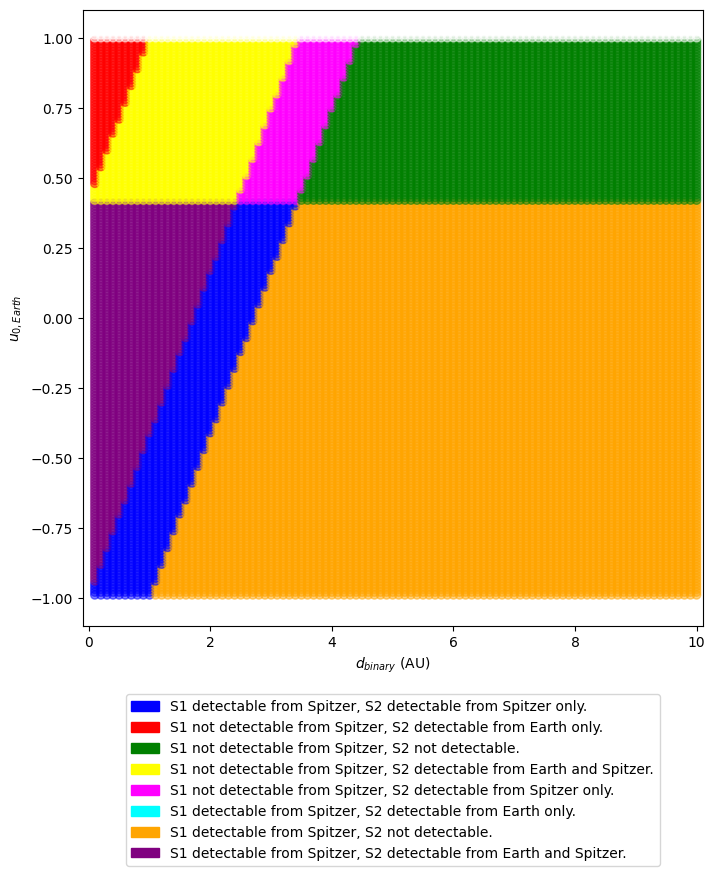

no of blue: 1410
number blue (detectable from Spitzer only) samples: 1410
3.516209476309227 %
number red samples: 257
0.6408977556109726 %
number green (detectable from both Earth and Spitzer) samples: 3545
8.840399002493765 %
number yellow (detectable from Earth only) samples: 1418
3.536159600997506 %
number magenta samples: 580
1.4463840399002494 %
number cyan samples: 0
0.0 %
number orange samples: 11036
27.521197007481298 %
number purple samples: 1654
4.124688279301745 %


In [ ]:
# Visualizes the results of the above cell for arrays of data points.
import seaborn as sns

u0_array = np.linspace(-2, 2, 401)  # Units of theta_E
phi_array = np.linspace(0, 180, 181) # degrees
dbinary_array = np.arange(0.1, 10.1, 0.1) #swap to logspace #In AU

#print(len(u0_array))
#print(len(dbinary_array))

n = -90 #phi_binary = 0/360 gives the most blues.

detection_grid = Spitzer_detectable(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)
#detection_grid = Spitzer_detectable_new(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)

#print the shape of detection grid


for i in range(1, len(u0_array)):
    for j in [90]: # 90˚ is max, 0/180˚ is min. So the range for relevant values of phi is 0-180˚.t
        sd = Spitzer_detectable(0.2, 7000, 8500, u0_array[i], j, n, dbinary_array)
        detection_grid = np.vstack((detection_grid, sd))
print(detection_grid.shape)
#for i in range(1, len(u0_array)):
    #for j in [90]: # 90˚ is max, 0/180˚ is min. So the range for relevant values of phi is 0-180˚.
        #sd = Spitzer_detectable_new(0.2, 7000, 8500, u0_array[i], j, n, dbinary_array)
        #detection_grid = np.vstack((detection_grid, sd))

X, Y = np.meshgrid(dbinary_array, u0_array) # To put d_binary in units of thetaE: (np.divide(dbinary_array,einstein_radius(0.2, 7000, 8500)))
print(X.shape, Y.shape)
print(X.size, Y.size)

# colors = np.array(["#000000", "#0072B2", "#999999", "#009E73", "#F0E442", "#CC79A7",
                   # "#56B4E9", "#D55E00", "#E69F00"])

colors = np.array(["black", "blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple", "white", "white", "white", "white",
                   "white", "white", "white"])

#colors = sns.color_palette("colorblind", 9)

# Dictionary to assign each output to a number.
Spitzer_detectable_outputs = {"aceg":1, "adfh":2, "adeh":3, "adfg":4, "adeg":5, "acfh":6,
                              "aceh":7,"acfg":8,  "bdfh":9, "bdeh":10,
                              "bdfg":11, "bdeg":12, "bcfh":13, "bceh":14,
                              "bceg":15, "bcfg":16}

for i in range(len(detection_grid)):
    for j in range(len(detection_grid[0])):
        detection_grid[i,j] = Spitzer_detectable_outputs[detection_grid[i,j]]

numbers = detection_grid.astype(int)
subs_arr = colors[numbers]
#print(subs_arr.shape)
#print(subs_arr.size)

import matplotlib.patches as mpatches

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X.flatten(), Y.flatten(), color = subs_arr.flatten(), alpha = 0.5)
# ax.set_xlim(10e-2,10e1)
# ax.set_xscale("log")
ax.set_xlabel(r'$d_{binary}$ (AU)')
ax.set_ylabel(r'$u_{0,Earth}$')
ax.set_xlim(-0.1, 10.1)
ax.set_ylim(-1.1, 1.1)

blue_patch = mpatches.Patch(color='blue', label="S1 detectable from Spitzer, S2 detectable from Spitzer only.")
red_patch = mpatches.Patch(color='red', label="S1 not detectable from Spitzer, S2 detectable from Earth only.")
green_patch = mpatches.Patch(color='green', label="S1 not detectable from Spitzer, S2 not detectable.")
yellow_patch = mpatches.Patch(color='yellow', label="S1 not detectable from Spitzer, S2 detectable from Earth and Spitzer.")
magenta_patch = mpatches.Patch(color='magenta', label="S1 not detectable from Spitzer, S2 detectable from Spitzer only.")
cyan_patch = mpatches.Patch(color='cyan', label="S1 detectable from Spitzer, S2 detectable from Earth only.")
orange_patch = mpatches.Patch(color='orange', label="S1 detectable from Spitzer, S2 not detectable.")
purple_patch = mpatches.Patch(color='purple', label="S1 detectable from Spitzer, S2 detectable from Earth and Spitzer.")

ax.legend(handles=[blue_patch, red_patch, green_patch, yellow_patch, magenta_patch, cyan_patch,
                   orange_patch, purple_patch], bbox_to_anchor=(0.5, -0.1), loc="upper center")
# ax.text(4, -0.25, "S1 detectable from Earth and Spitzer, \n S2 not detectable.")
# ax.legend([subs_arr==1, subs_arr==2, subs_arr==3,
           # subs_arr==4, subs_arr==5, subs_arr==6,
           # subs_arr==7, subs_arr==8], ["S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.",
            # "S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.",
            # "S1 detectable from Earth but not Spitzer, S2 not detectable.",
            # "S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.",
            # "S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.",
            # "S1 detectable from Earth and Spitzer, S2 detectable from Earth only.",
            # "S1 detectable from Earth and Spitzer, S2 not detectable.",
            # "S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer."])
plt.savefig("parameter_space.png", bbox_inches='tight')
plt.show()


#print(X.shape, Y.shape)
num_dots = X.shape[0] * X.shape[1]  #20100
#print(num_dots)
#print(subs_arr.shape)
# count the number of 1's in detection_grid
#print(detection_grid[1])
#print(numbers.shape)
blues_count = np.where(numbers == 1)[0].size
print('no of blue:', blues_count)

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 1:
            test_count += 1
print('number blue (detectable from Spitzer only) samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 2:
            test_count += 1
print('number red samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 3:
            test_count += 1
print('number green (detectable from both Earth and Spitzer) samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 4:
            test_count += 1
print('number yellow (detectable from Earth only) samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 5:
            test_count += 1
print('number magenta samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 6:
            test_count += 1
print('number cyan samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 7:
            test_count += 1
print('number orange samples:', test_count)
print(100 * test_count / num_dots, '%')

test_count = 0
for i in range(401):
    for j in range(100):
        if numbers[i,j] == 8:
            test_count += 1
print('number purple samples:', test_count)
print(100 * test_count / num_dots, '%')

# To make the model 3D (if this is practical/useful):
# - vertical angle between Earth and Spitzer
# - vertical angle(s) between the observatories and the lens
# - vertical angle(s) between the observatories and the sources
# - vertical angle between the lens and the sources
# - vertical angle between Source 1 and Source 2
# - something to account for motion (observatories, sources, etc.)?

In [ ]:
def Spitzer_detectable_array(u0_array=u0_array, dbinary_array=dbinary_array, ml=1.0, dl=4000, ds=8500, phi_binary=-90):
    """
    Need to write docstrings for this
    """
    Spitzer_detectable_outputs = {"adfh":1, "adeh":2, "adfg":3, "adeg":4, "acfh":5,
                              "aceh":6,"acfg":7, "aceg":8, "bdfh":9, "bdeh":10,
                              "bdfg":11, "bdeg":12, "bcfh":13, "bceh":14,
                              "bceg":15, "bcfg":16}

    final_grid = np.array(Spitzer_detectable(ml, dl, ds, u0_array[0], 90, phi_binary, dbinary_array))
    #X, Y = np.meshgrid(u0_array, phi_array)
    #X_flat = X.flatten()
    #Y_flat = Y.flatten()
    #sd = np.array(Spitzer_detectable(ml*M_sol, dl*parsec, ds*parsec, X_flat, Y_flat, -90, dbinary_array*AU))
    for i in range(1, len(u0_array)):
        for j in range(0, 360): # I want to create individual arrays for each set of Spitzer_detectable values for each angle.
            sd = Spitzer_detectable(ml, dl, ds, u0_array[i], j, phi_binary, dbinary_array)
            final_grid = np.vstack((final_grid, sd))
            final_grid[i,j] = Spitzer_detectable_outputs[final_grid[i,j]]
            #print(i, j)
            #final_grid = np.vstack((final_grid, sd))
            #final_grid[i, j] = sd

    #final_grid = sd.reshape(len(u0_array), 181, len(dbinary_array))
    #print(final_grid.shape)
    fg_integers = final_grid.astype(int)
    blue = np.where(fg_integers==1, fg_integers, fg_integers*0)
    return blue

#n = 3 # number of samples you want

#Ds = np.sqrt(np.random.uniform(500**2, 8500**2, n)) # in parsecs
#Dl = np.sqrt(np.random.uniform(2000**2, 5000**2, n)) # also in parsecs
#dbinary_array = np.log(np.random.lognormal(40, 1.5, n)) # in AU

#fg = Spitzer_detectable_array(u0_array, dbinary_array, ml=0.4)#=dbinary_array, dl=Dl, ds=Ds)
np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
#print(fg)

#detection_grid = Spitzer_detectable(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)
fg1 = Spitzer_detectable_array(u0_array, dbinary_array, ml=0.2, dl=7000, ds=8500)
print(np.sum(fg1)/fg1.size)

#blues_array = np.array([])
#for k in range(len(fg)): # Then, ideally, this loop would count the number of 1s in each array, appending that number to a new array.
# The data in this new array is what I would plot with respect to phi as the output of my function.
    #blue_count = np.count_nonzero(fg[k] == 1) # What I want is for it to count the number of 1s in each array in final_grid.
#for k in range(len(u0_array)*90*len(dbinary_array)):

#plt.plot(np.arange(0, 91, 1), blues_array)
#plt.xlabel('Phi (Degrees)')
#plt.ylabel('Spitzer-only detectable binary source events')
#plt.show()


IndexError: index 100 is out of bounds for axis 1 with size 100

In [ ]:
# New Spitzer_detectable_array function inputing u0_spitzer (like the actual data) instead of u0_earth.

def Spitzer_detectable_array_new(u0_array=u0_array, dbinary_array=dbinary_array, ml=1.0, dl=4000, ds=8500, phi_binary=-90):

    """
    Same as original Spitzer_detectable_array function, but uses
    Spitzer_detectable_new instead of Spitzer_detectable.

    """

    final_grid = np.zeros((len(u0_array), 360, len(dbinary_array)))

    for i in range(1, len(u0_array)):
        for j in range(0, 360): # I want to create individual arrays for each set of Spitzer_detectable values for each angle.
            sd = np.array(Spitzer_detectable_new(ml, dl, ds, u0_array[i], j, phi_binary, dbinary_array))
            final_grid[i, j, :] = sd
    fg_integers = final_grid.astype(int)
    blue = np.where(fg_integers == 1, fg_integers, fg_integers*0)
    return blue

test2 = Spitzer_detectable_array_new(u0_array, dbinary_array)
print(test2)
print(np.sum(test2))

In [ ]:
# 2D histogram the results

#print(fg_integers)
blue_marginalize_u0 = np.sum(test2, axis=0)
blue_marginalize_phi = np.sum(test2, axis=1)
blue_marginalize_db = np.sum(test2, axis=2)

#print(blue)
#print(blue_marginalize_u0.shape)
#print(blue_marginalize_phi.shape)
#print(blue_marginalize_db.shape)

# mariginalize u0
plt.figure(figsize=(8, 6)) # Adjust figure size if needed
plt.imshow(blue_marginalize_u0, cmap='viridis', aspect='auto')
plt.colorbar(label='Value') # Add a color bar to show scale
plt.title(r'marginalized $u_0$')
plt.xlabel(r'$d_{binary}$')
plt.ylabel(r'$\phi$')
plt.show()

# marginalize phi
plt.figure(figsize=(8, 6)) # Adjust figure size if needed
plt.imshow(blue_marginalize_phi, cmap='viridis', aspect='auto')
plt.colorbar(label='Value') # Add a color bar to show scale
plt.title(r'marginalized $phi$')
plt.xlabel(r'$d_b$')
plt.ylabel(r'$u_0$')
plt.show()

# marginalize db
plt.figure(figsize=(8, 6)) # Adjust figure size if needed
plt.imshow(blue_marginalize_db, cmap='viridis', aspect='auto')
plt.colorbar(label='Value') # Add a color bar to show scale
plt.title(r'marginalized $d_b$')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$u_0$')
plt.show()

# Add total percentage
N = test2.shape[0]*test2.shape[1]*test2.shape[2]
#print(N)

#print(np.sum(blue))

percentage = np.sum(test2)/N * 100
print(f"{percentage:0.2f}%")

In [ ]:
# Let's start with a pi_rel histogram from uniform d
D1, Dn  = 0.5**2, 8.5**2
print(D1, Dn)

def pi_rel(DL,DS):
    ''' Find pi_rel

    Inputs:
    --------
    DL:                 arr or float
                        kpc
    DS:                 arr or float
                        default is 8 - galactic center
                        kpc

    Output:
    --------
    pirel_mas:          arr or float
                        mas (milliarcseconds)


    Notes:
    -------
    $\pi_{rel} = \rm{au}(\frac{1}{D_L}-\frac{1}{D_S})$,
    the au just means we are working in parsecs distances and as for our angles because, by definition,
    1 parsec is the distance to something with a parallax angle of 1 as.

    $d = \frac{1}{p}$,
    where $d$ is the distance to the star in parsecs (1 pc = 3.26 light-years)
    and $p$ is the parallax angle in arc seconds.
    '''
    pirel_mas = (1./(DL)-1.0/(DS))

    return pirel_mas

n=1000
Ds = np.sqrt(np.linspace(D1, Dn, n))
params = np.vstack(np.meshgrid(Ds, Ds)).reshape(2,-1).T
pirel_mas = pi_rel(params[:,0],params[:,1])
params = params[pirel_mas>0]
print(params)

plt.figure()
plt.plot(params[:,0],params[:,1],'k.')
plt.xlabel(r'$D_L$')
plt.ylabel(r'$D_S$')
plt.show()

In [ ]:
"""
import numpy as np # Because I'm tired of running the entire notebook every single time.
import matplotlib.pyplot as plt

# Test random values for Dl, Ds
def random_d(u0_array, Ds=8500, Dl=4000, dbinary_array=dbinary_array, ml=1.0): #need to add in default values for ds, dl, dbinary_array

    pretend this is a docstring

    #Ds = np.sqrt(np.random.uniform(500**2, 8500**2, n)) # in parsecs
    #Dl = np.sqrt(np.random.uniform(2000**2, 5000**2, n)) # also in parsecs
    #dbinary_array = np.log(np.random.lognormal(40, 1.5, n)) # in AU

    #print(Ds)
    #print(Dl)
    #print(dbinary_array)

    params = np.vstack(np.meshgrid(Dl/1000, Ds/1000)).reshape(2,-1).T
    pirel_mas = pi_rel(params[:,0],params[:,1])
    params = params[pirel_mas > 0]
    nn = params.shape[0]
    rd_output = np.zeros((nn, u0_array.shape[0], 181, dbinary_array.shape[0]))
    random_blue = np.zeros(nn)
    #print(nn)
    #print(pirel_mas)
    #print(params)
    for i in range(nn):
        sda_rand = Spitzer_detectable_array(u0_array, dbinary_array, ds=params[i,1], dl=params[i,0])
        #print(sda_rand)
        rd_output[i] = sda_rand
        N = sda_rand.shape[0]*sda_rand.shape[1]*sda_rand.shape[2]
        #print(N)
        random_blue[i] = np.sum(rd_output)
        #print(random_blue)
        percentage = np.sum(rd_output)/N * 100
        print(f"{percentage:0.2f}%")
        #np.save('rds_output.npy', percentage)
    return random_blue # Not quite sure what I should have it return...maybe also rd_output

#test = random_d(3, u0_array, dbinary_array)
#print(test)

#dbinary_array = np.log10(np.random.normal(10**30, 10**1.5, 200)) #always returns the first exponent for some reason...
#dbinary_array = np.log(np.random.lognormal(40, 1.5, 3))
#print(dbinary_array)

n = 3 # number of samples you want

Ds = np.sqrt(np.random.uniform(500**2, 8500**2, n)) # in parsecs
Dl = np.sqrt(np.random.uniform(500**2, 5000**2, n)) # also in parsecs
dbinary_array = np.log(np.random.lognormal(40, 1.5, n)) # in AU

test = random_d(u0_array, Ds, Dl, dbinary_array)
print(test)

#rd_output = np.array([])
#rd_output = np.append(rd_output, test)
#print(rd_output)

# Save the array to an .npy file
#np.save('rd_output.npy', rd_output)
#from google.colab import files
#files.download('rd_output.npy')
#loaded_data = np.load('rd_output.npy')
#print(loaded_data)
"""


In [ ]:
# Generating an SSH key to access private repo
!ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -N ''
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
!cat ~/.ssh/id_rsa.pub

Generating public/private rsa key pair.
Created directory '/root/.ssh'.
Your identification has been saved in /root/.ssh/id_rsa
Your public key has been saved in /root/.ssh/id_rsa.pub
The key fingerprint is:
SHA256:IqvZZNAjmpcqzdtaj/AhnlVcTGxVttOGjUvaSQ5YayQ root@a4c90c5905ac
The key's randomart image is:
+---[RSA 4096]----+
|       .E.+.o    |
|       oo= o *   |
|       .+ + B +  |
|   . . . . B =   |
|  o + + S . =    |
| o + = .         |
|oo= B            |
|.+o# +           |
|o Bo= .          |
+----[SHA256]-----+
# github.com:22 SSH-2.0-57acd57a
ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDYq3dzYZQ4XJ2FNNUME7pvg+CZ1qC+3agNvGRC1YCtscJjXcPLcTiVU+CRwUudm7fM/GbXLS4B40mhxBybTnrWPMc1VPcWLq0gB2nGHWV67hjJPnZOZMfhCUMl03KYtYcfmJej7zLIjHR5zON9sgfA9Uac6AfnTvR7cn0c11xUQxjuk+izGnxW0ZBMGs3vNLfxjcLpaDH3YoFczSFLYksc0zeKhjEobv+oaBziRNTRVYORpJN3p8XLF7l+MWlRbFte1IdO5xLe+rG4KtqZTVSKAg9gNlCg17k1aRej/dPSkcFhPn7i3gbC4s0uGyLwR/9MVox6eVLalyc6hgEns6A75y2X0JJCUJyXd0cwLmaab3oxUQPlG5fe+R6ZyceudzOkA46ALfYBqgwjJe0Z

In [ ]:
# Clone the repository
!ssh -T git@github.com
!git clone git@github.com:AmberLee2427/PopSyCLE-table.git
!cd PopSyCLE-table

Hi CatherineRexer24! You've successfully authenticated, but GitHub does not provide shell access.
Cloning into 'PopSyCLE-table'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 89 (delta 49), reused 62 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 24.33 MiB | 18.22 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
# Load the table
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

table = pd.read_csv("PopSyCLE-table/data/popsycle_table_with_calcs.csv")
A_max = (table["u0"]**2+2)/(abs(table["u0"])*np.sqrt(table["u0"]**2+4))
#print(table)
# new_table = table[np.where(table["I_S"] - 2.5 * np.log10(A_max) < 17)[0]]

new_table = table[table["I_S"] - 2.5 * np.log10(A_max) < 17]
print(new_table.index)
print(new_table.shape)

indices = new_table.index
index = table.index
print(index[5])
print(indices[5])

# Print the first few rows of the table
#print(new_table.head())
#print(new_table.shape)

D_L = new_table['D_L_kpc']
#I_S = new_table['I_S']
#print(I_S)

#print(D_L)
#M_L = new_table['M_L']
#print(sum(M_L)/len(M_L))

RangeIndex(start=0, stop=2389, step=1)
(2389, 26)
5
5


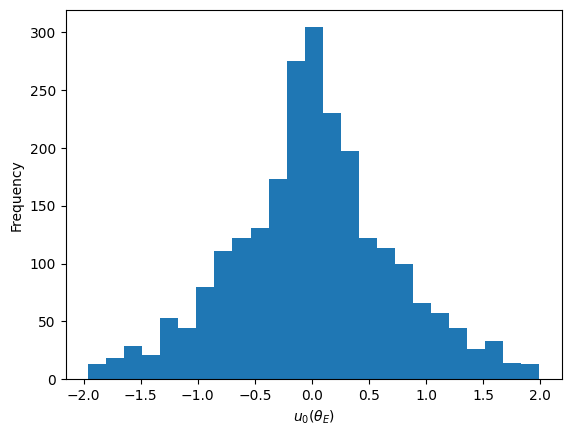

-0.0017945054325595
0.005065311243793822


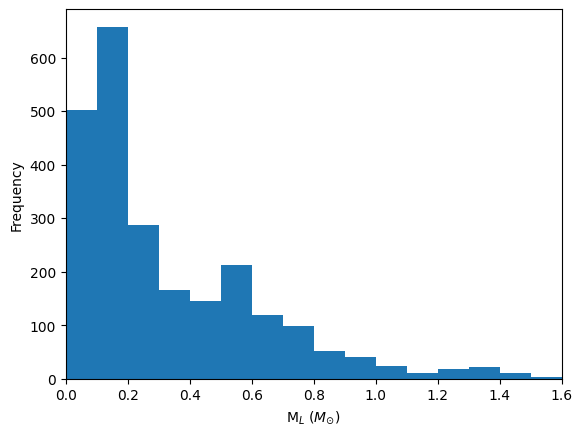

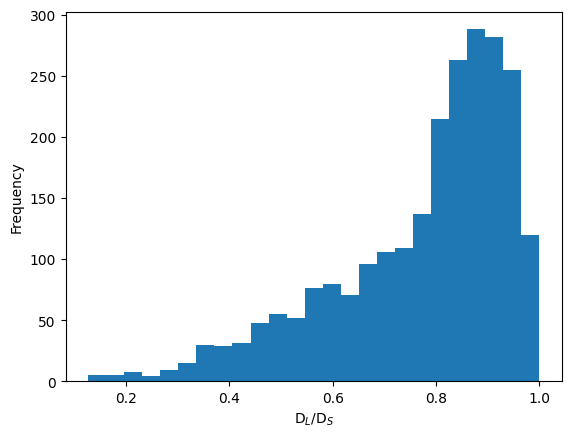

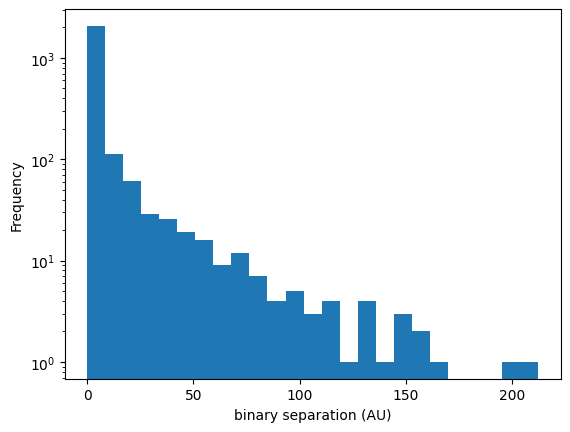

0.3721481574269861


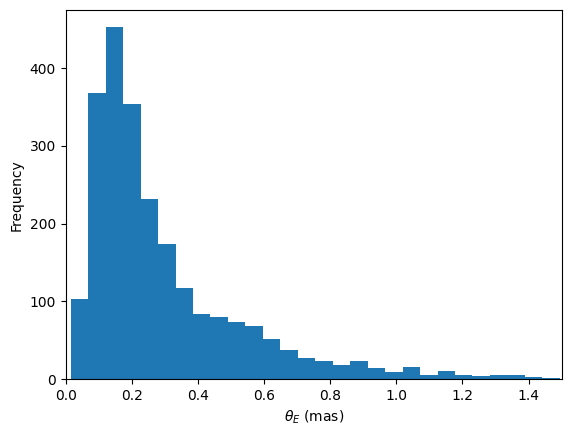

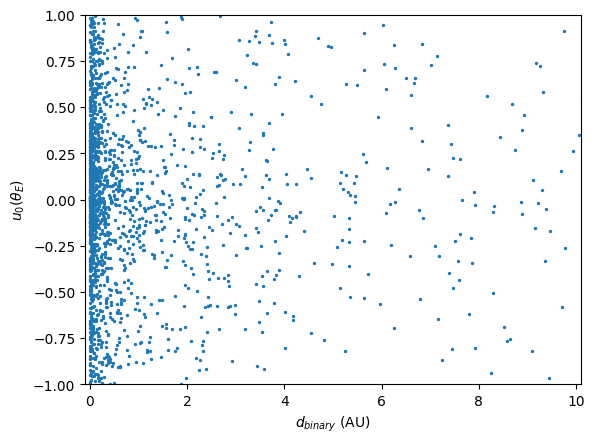

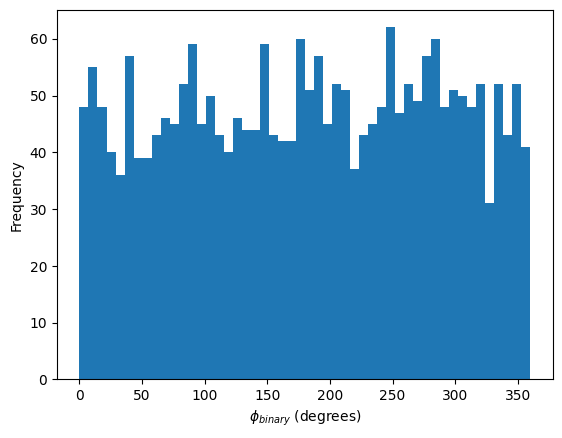

In [ ]:
# Plotting histograms to show distribution of parameters.

u0s = table['u0']
plt.hist(u0s, bins=25)
plt.xlabel('$u_0 (θ_E)$')
plt.ylabel('Frequency')
plt.savefig("u0_hist.png")
plt.show()
print(np.median(u0s))
print(np.mean(u0s))

mls = table['M_L']
plt.hist(mls, bins=np.arange(0, 2.5, 0.1))
plt.xlim(0, 1.6)
plt.xlabel('M$_L$ $(M_{\\odot})$')
plt.ylabel('Frequency')
plt.savefig("ml_hist.png")
plt.show()

d_ratio = D_L/table['D_S_kpc']
plt.hist(d_ratio, bins=25)
plt.xlabel('D$_L$/D$_S$')
plt.ylabel('Frequency')
plt.savefig("d_hist.png")
plt.show()

binaryseparation = table['binary_sep_au']
plt.hist(binaryseparation, bins=25)#np.arange(0, 1, 0.05))
#plt.xlim(0, 50)
plt.yscale('log')
plt.xlabel('binary separation (AU)')
plt.ylabel('Frequency')
plt.savefig("dbinary_hist.png")
plt.show()
print(np.median(binaryseparation))

thetae = table['theta_E_mas']
plt.hist(thetae, bins=50)
plt.xlim(0, 1.5)
plt.xlabel('$θ_E$ (mas)')
plt.ylabel('Frequency')
plt.savefig("thetae_hist.png")
plt.show()

plt.scatter(binaryseparation, u0s, s=2)
plt.xlim(-0.1, 10.1)
plt.ylim(-1,1)
plt.xlabel('$d_{binary}$ (AU)')
plt.ylabel('$u_0 (θ_E)$')
plt.savefig("dbinary_u0_scatter.png")
plt.show()

phi_binaries = table["binary_phi_deg"]
plt.hist(phi_binaries, bins=50)
plt.xlabel('$\phi_{binary}$ (degrees)')
plt.ylabel('Frequency')
plt.savefig("phibinary_hist.png")
plt.show()

(401, 100)
(401, 100) (401, 100)
40100 40100


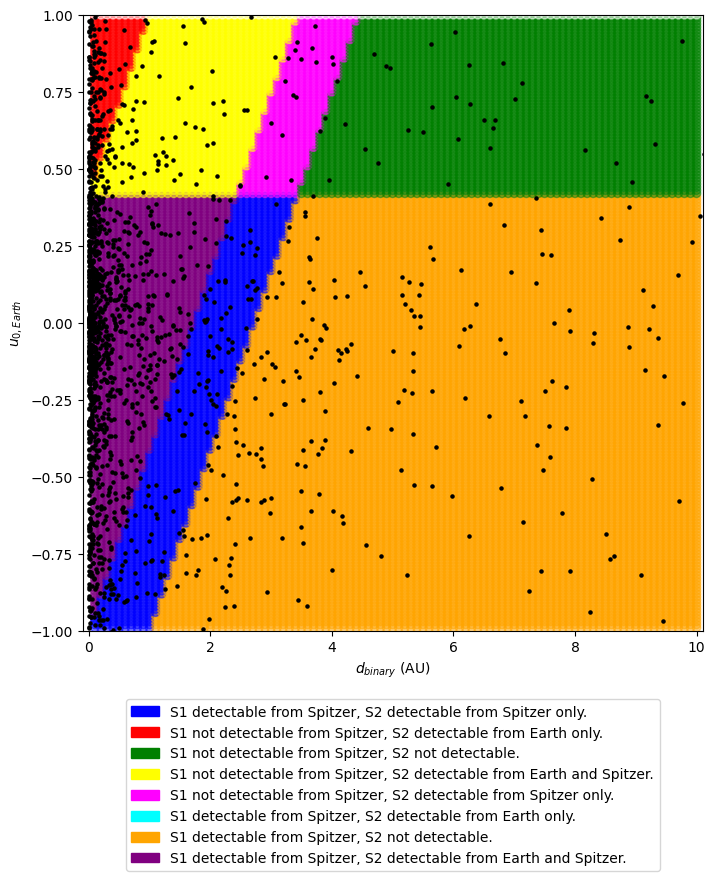

In [ ]:
u0_array = np.linspace(-2, 2, 401)  # Units of theta_E
phi_array = np.linspace(0, 180, 181) # degrees
dbinary_array = np.arange(0.1, 10.1, 0.1) #swap to logspace #In AU

#print(len(u0_array))
#print(len(dbinary_array))

n = -90 #phi_binary = 0/360 gives the most blues.

detection_grid = Spitzer_detectable(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)
#detection_grid = Spitzer_detectable_new(0.2, 7000, 8500, u0_array[0], 90, n, dbinary_array)

#print the shape of detection grid


for i in range(1, len(u0_array)):
    for j in [90]: # 90˚ is max, 0/180˚ is min. So the range for relevant values of phi is 0-180˚.t
        sd = Spitzer_detectable(0.2, 7000, 8500, u0_array[i], j, n, dbinary_array)
        detection_grid = np.vstack((detection_grid, sd))
print(detection_grid.shape)
#for i in range(1, len(u0_array)):
    #for j in [90]: # 90˚ is max, 0/180˚ is min. So the range for relevant values of phi is 0-180˚.
        #sd = Spitzer_detectable_new(0.2, 7000, 8500, u0_array[i], j, n, dbinary_array)
        #detection_grid = np.vstack((detection_grid, sd))

X, Y = np.meshgrid(dbinary_array, u0_array) # To put d_binary in units of thetaE: (np.divide(dbinary_array,einstein_radius(0.2, 7000, 8500)))
print(X.shape, Y.shape)
print(X.size, Y.size)

colors = np.array(["black", "blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple", "white", "white", "white", "white",
                   "white", "white", "white"])

# Dictionary to assign each output to a number.
Spitzer_detectable_outputs = {"aceg":1, "adfh":2, "adeh":3, "adfg":4, "adeg":5, "acfh":6,
                              "aceh":7,"acfg":8,  "bdfh":9, "bdeh":10,
                              "bdfg":11, "bdeg":12, "bcfh":13, "bceh":14,
                              "bceg":15, "bcfg":16}

for i in range(len(detection_grid)):
    for j in range(len(detection_grid[0])):
        detection_grid[i,j] = Spitzer_detectable_outputs[detection_grid[i,j]]

numbers = detection_grid.astype(int)
subs_arr = colors[numbers]
#print(subs_arr.shape)
#print(subs_arr.size)

import matplotlib.patches as mpatches

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X.flatten(), Y.flatten(), color = subs_arr.flatten(), alpha = 0.5)
ax.scatter(binaryseparation, u0s, color = "black", s=5)
# ax.set_xlim(10e-2,10e1)
# ax.set_xscale("log")
ax.set_xlabel(r'$d_{binary}$ (AU)')
ax.set_ylabel(r'$u_{0,Earth}$')
ax.set_xlim(-0.1, 10.1)
ax.set_ylim(-1, 1)

blue_patch = mpatches.Patch(color='blue', label="S1 detectable from Spitzer, S2 detectable from Spitzer only.")
red_patch = mpatches.Patch(color='red', label="S1 not detectable from Spitzer, S2 detectable from Earth only.")
green_patch = mpatches.Patch(color='green', label="S1 not detectable from Spitzer, S2 not detectable.")
yellow_patch = mpatches.Patch(color='yellow', label="S1 not detectable from Spitzer, S2 detectable from Earth and Spitzer.")
magenta_patch = mpatches.Patch(color='magenta', label="S1 not detectable from Spitzer, S2 detectable from Spitzer only.")
cyan_patch = mpatches.Patch(color='cyan', label="S1 detectable from Spitzer, S2 detectable from Earth only.")
orange_patch = mpatches.Patch(color='orange', label="S1 detectable from Spitzer, S2 not detectable.")
purple_patch = mpatches.Patch(color='purple', label="S1 detectable from Spitzer, S2 detectable from Earth and Spitzer.")

ax.legend(handles=[blue_patch, red_patch, green_patch, yellow_patch, magenta_patch, cyan_patch,
                   orange_patch, purple_patch], bbox_to_anchor=(0.5, -0.1), loc="upper center")
plt.savefig("parameter_space_w_data.png", bbox_inches='tight')
plt.show()

In [ ]:
# Load data into spitzer_detectable_array function
parsec = 3.086e16 # So I don't have to go back and run the beginning cells
AU = 1.5e11
M_sol = 2e30

#real_data_array = np.zeros(len(table))
real_data_yay_array = Spitzer_detectable_array(u0_array=np.array([table["u0"][0]]),
                                             dbinary_array=np.array([table["binary_sep_au"][0]]), ml=np.array([table["M_L"][0]]),
                                             dl=np.array([table["D_L_kpc"][0]*1000]), ds=np.array([table["D_S_kpc"][0]*1000]))

for i in range(1,len(table)):
    real_data_yay = Spitzer_detectable_array(u0_array=np.array([table["u0"][i]]),
                                             dbinary_array=np.array([table["binary_sep_au"][i]]), ml=np.array([table["M_L"][i]]),
                                             dl=np.array([table["D_L_kpc"][i]*1000]), ds=np.array([table["D_S_kpc"][i]*1000]))
    #print(real_data_yay)
    real_data_yay_array = np.vstack((real_data_yay_array, real_data_yay))
#print(real_data_yay_array)
#print(len(real_data_array))
print(np.sum(real_data_yay_array))

#real_data_yay_array_new = np.array([])
#for i in range(len(table)):
    #real_data_new = Spitzer_detectable_array_new(u0_array=np.array([table["u0"][i]]),
                                                 #dbinary_array=np.array([table["binary_sep_au"][i]]), ml=np.array([table["M_L"][i]]),
                                                 #dl=np.array([table["D_L_kpc"][i]*1000]), ds=np.array([table["D_S_kpc"][i]*1000]))
    #print(real_data_yay)
    #real_data_yay_array_new = np.append(real_data_yay_array, real_data_new)
#print(real_data_array)
#print(sum(real_data_yay_array_new))

#real_data_array = np.array([])
#for i in range(len(table)):
    #real_data = Spitzer_detectable(ml=np.array([table["M_L"][i]]),
                                   #dl=np.array([table["D_L_kpc"][i]*1000]), ds=np.array([table["D_S_kpc"][i]*1000]),
                                   #u0_earth=np.array([table["u0"][i]]), phi=np.linspace(1,181), phi_binary = 0,
                                   #d_binary=np.array([table["binary_sep_au"][i]]))
    #print(real_data_yay)
    #real_data_array = np.append(real_data_array, real_data)
#print(sum(real_data_array))
#print(np.where(real_data_array == 1))

#np.save('real_data_array.npy', real_data_array)

#test = Spitzer_detectable(ml=np.array([table["M_L"][1]]), dl=np.array([table["D_L_kpc"][1]*1000]),
                          #ds=np.array([table["D_S_kpc"][1]*1000]), u0_earth=np.array([table["u0"][1]]),
                          #phi=np.linspace(1,181), phi_binary = 0, d_binary=np.array([table["binary_sep_au"][1]]))
#print(test)

#test2 = Spitzer_detectable_array(u0_array=np.array([table["u0"][11]]), dbinary_array=np.array([table["binary_sep_au"][11]]),
                                 #ml=np.array([table["M_L"][11]]), dl=np.array([table["D_L_kpc"][11]*1000]),
                                 #ds=np.array([table["D_S_kpc"][11]*1000]))
#print(test2)

ValueError: invalid literal for int() with base 10: np.str_('acfg')

1.5101623180317194


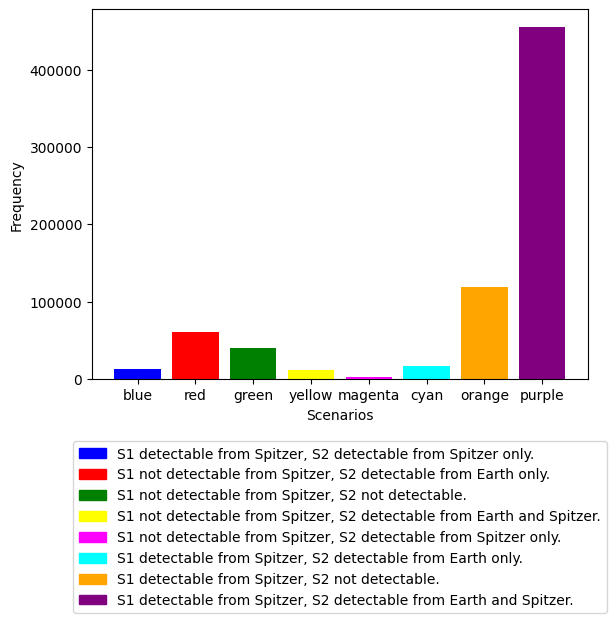

0.8966201551444426
(2389, 360)


In [ ]:
# Plotting the distribution of different numbers/colors for the real data (in the same manner as the simulation above).

#Initialize the array.
real_data_array = np.array(Spitzer_detectable(ml=np.array([table["M_L"][0]]),
                                   dl=np.array([table["D_L_kpc"][0]*1000]),
                                   ds=np.array([table["D_S_kpc"][0]*1000]),
                                   u0_earth=np.array([table["u0"][0]]),
                                   phi=np.linspace(0,360,360),
                                   phi_binary=np.array([table["binary_phi_deg"][0]]),
                                   d_binary=np.array([table["binary_sep_au"][0]])))

# Run the data.
for i in indices[1:]:
    real_data = Spitzer_detectable(ml=np.array([table["M_L"][i]]),
                                   dl=np.array([table["D_L_kpc"][i]*1000]),
                                   ds=np.array([table["D_S_kpc"][i]*1000]),
                                   u0_earth=np.array([table["u0"][i]]),
                                   phi=np.linspace(0,360,360),
                                   phi_binary=np.array(table["binary_phi_deg"][i]),
                                   d_binary=np.array([table["binary_sep_au"][i]]))
    real_data_array = np.vstack((real_data_array, real_data))

# Dictionary to assign each output to a number.
Spitzer_detectable_outputs = {"aceg":1, "adfh":2, "adeh":3, "adfg":4, "adeg":5,
                              "acfh":6, "aceh":7, "acfg":8, "bdfh":9, "bdeh":10,
                              "bdfg":11, "bdeg":12, "bcfh":13, "bceh":14,
                              "bceg":15, "bcfg":16}

for i in range(len(real_data_array)):
    for j in range(len(real_data_array[0])):
        real_data_array[i,j] = Spitzer_detectable_outputs[real_data_array[i,j]]

real_data_array = real_data_array.astype(int)
#Initialize the array.
"""
real_data_array = np.array(Spitzer_detectable_new(ml=np.array([table["M_L"][0]]),
                                   dl=np.array([table["D_L_kpc"][0]*1000]), ds=np.array([table["D_S_kpc"][0]*1000]),
                                   u0_spitzer=np.array([table["u0"][0]]), phi=np.linspace(0,360,360), phi_binary = -90,
                                   d_binary=np.array([table["binary_sep_au"][0]])))

# Run the data.
for i in range(1, len(table)):
    real_data = Spitzer_detectable_new(ml=np.array([table["M_L"][i]]),
                                   dl=np.array([table["D_L_kpc"][i]*1000]), ds=np.array([table["D_S_kpc"][i]*1000]),
                                   u0_spitzer=np.array([table["u0"][i]]), phi=np.linspace(0,360,360), phi_binary = -90,
                                   d_binary=np.array([table["binary_sep_au"][i]]))
    real_data_array = np.vstack((real_data_array, real_data))
    """


# Count the values for each color.
test_count1 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 1:
            test_count1 += 1

test_count2 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 2:
            test_count2 += 1

test_count3 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 3:
            test_count3 += 1

test_count4 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 4:
            test_count4 += 1

test_count5 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 5:
            test_count5 += 1

test_count6 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 6:
            test_count6 += 1

test_count7 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 7:
            test_count7 += 1

test_count8 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 8:
            test_count8 += 1

test_count9 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 9:
            test_count9 += 1

test_count10 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 10:
            test_count10 += 1

test_count11 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 11:
            test_count11 += 1

test_count12 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 12:
            test_count12 += 1

test_count13 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 13:
            test_count13 += 1

test_count14 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 14:
            test_count14 += 1

test_count15 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 15:
            test_count15 += 1

test_count16 = 0
for i in range(len(real_data_array)):
    for j in range(360):
        if real_data_array[i,j] == 16:
            test_count16 += 1

print(100*test_count1/(len(real_data_array)*360))

# Make the plot.
categories = ["blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple"]#, "darkblue", "darkred", "darkgreen", "gold",
                   #"darkmagenta", "darkcyan", "darkorange", "black"]
counts = [test_count1, test_count2, test_count3, test_count4, test_count5,
          test_count6, test_count7, test_count8]#, test_count9, test_count10,
          #test_count11, test_count12, test_count13, test_count14, test_count15,
          #test_count16]
colors = np.array(["blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple"])#, "darkblue", "darkred", "darkgreen", "gold",
                   #"darkmagenta", "darkcyan", "darkorange", "black"])
# for the legend
blue_patch = mpatches.Patch(color='blue', label="S1 detectable from Spitzer, S2 detectable from Spitzer only.")
red_patch = mpatches.Patch(color='red', label="S1 not detectable from Spitzer, S2 detectable from Earth only.")
green_patch = mpatches.Patch(color='green', label="S1 not detectable from Spitzer, S2 not detectable.")
yellow_patch = mpatches.Patch(color='yellow', label="S1 not detectable from Spitzer, S2 detectable from Earth and Spitzer.")
magenta_patch = mpatches.Patch(color='magenta', label="S1 not detectable from Spitzer, S2 detectable from Spitzer only.")
cyan_patch = mpatches.Patch(color='cyan', label="S1 detectable from Spitzer, S2 detectable from Earth only.")
orange_patch = mpatches.Patch(color='orange', label="S1 detectable from Spitzer, S2 not detectable.")
purple_patch = mpatches.Patch(color='purple', label="S1 detectable from Spitzer, S2 detectable from Earth and Spitzer.")

# labeldict = {"blue":"S2 detectable from Spitzer only.",
             # "red":"S2 detectable from Earth only.",
             # "green":"S2 not detectable.",
             # "yellow":"S2 detectable from Earth and Spitzer.",
             # "magenta":"S2 detectable from Spitzer only.",
             # "cyan":"S2 detectable from Earth only.",
             # "orange":"S2 not detectable.",
             # "purple":"S2 detectable from Earth and Spitzer."}

# Plot the graph.
plt.bar(categories, counts, color=colors)#, label=labeldict[categories])
plt.xlabel('Scenarios')
plt.ylabel('Frequency')
plt.legend(handles=[blue_patch, red_patch, green_patch, yellow_patch, magenta_patch, cyan_patch,
                   orange_patch, purple_patch], bbox_to_anchor=(0.5, -0.15), loc="upper center")
# Adjust the plot's right margin to make space for the legend
#plt.subplots_adjust(right=0.7)

plt.savefig("bargraph.png", bbox_inches='tight')
plt.show()


print((test_count1/(test_count1 + test_count8 + test_count7)*100)*0.4051) # cut
print(real_data_array.shape)

#print(len(real_data_array))
#print(real_data_array.shape)

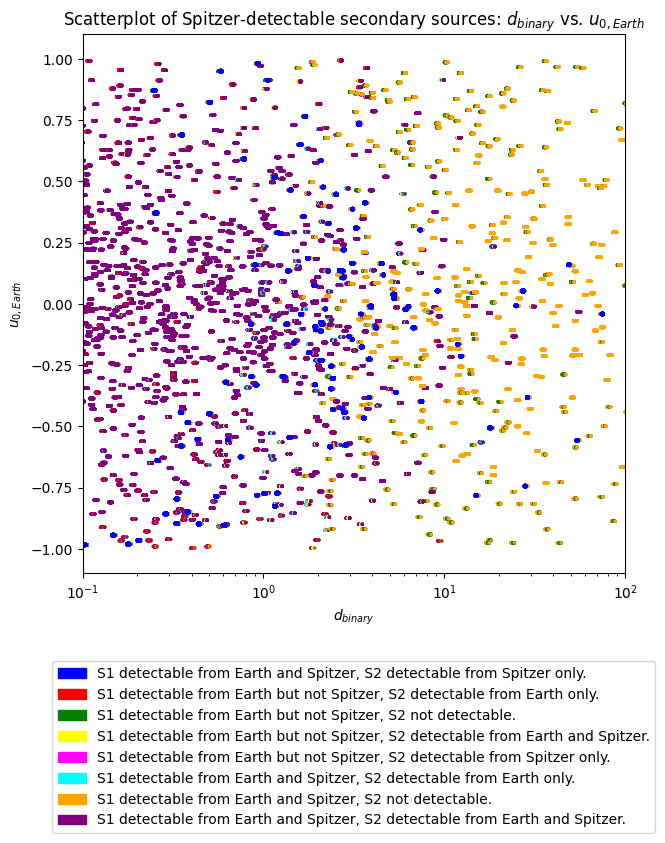

In [ ]:
# Make a scatterplot.

phi_test = np.ones(360)
#delta_db = np.logspace(-1, 0, 360)
u0_array_big = table["u0"][0]*phi_test
#d_binary_big = table["binary_sep_au"][0]*phi_test + np.logspace(table["binary_sep_au"][0]*0.1, table["binary_sep_au"][0]*10, 360)
d_binary_big = np.logspace(np.log10(table["binary_sep_au"][0])-0.01, np.log10(table["binary_sep_au"][0])+0.01, 360)
for i in indices[1:]:
    u0_array_big = np.vstack((u0_array_big, table["u0"][i]*phi_test))
    #d_binary_big = np.vstack((d_binary_big, table["binary_sep_au"][i]*phi_test + np.logspace(table["binary_sep_au"][i]*0.1, table["binary_sep_au"][i]*10, 360)))
    d_binary_big = np.vstack((d_binary_big, np.logspace(np.log10(table["binary_sep_au"][i])-0.01, np.log10(table["binary_sep_au"][i])+0.01, 360)))


numbers = real_data_array.astype(int)
colors = np.array(["black", "blue", "red", "green", "yellow", "magenta", "cyan",
                   "orange", "purple", "white", "white", "white", "white", "white",
                   "white", "white", "white"])
subs_arr = colors[numbers]
bluesplot = np.where(numbers.flatten() == 1)[0]

fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(d_binary_big.flatten(), u0_array_big.flatten(), color = subs_arr.flatten(), alpha = 0.5, s=2)
ax.scatter(d_binary_big.flatten()[bluesplot], u0_array_big.flatten()[bluesplot],
           color = subs_arr.flatten()[bluesplot], s=5) # Plot just the blues on top.

# For the legend:
blue_patch = mpatches.Patch(color='blue', label="S1 detectable from Earth and Spitzer, S2 detectable from Spitzer only.")
red_patch = mpatches.Patch(color='red', label="S1 detectable from Earth but not Spitzer, S2 detectable from Earth only.")
green_patch = mpatches.Patch(color='green', label="S1 detectable from Earth but not Spitzer, S2 not detectable.")
yellow_patch = mpatches.Patch(color='yellow', label="S1 detectable from Earth but not Spitzer, S2 detectable from Earth and Spitzer.")
magenta_patch = mpatches.Patch(color='magenta', label="S1 detectable from Earth but not Spitzer, S2 detectable from Spitzer only.")
cyan_patch = mpatches.Patch(color='cyan', label="S1 detectable from Earth and Spitzer, S2 detectable from Earth only.")
orange_patch = mpatches.Patch(color='orange', label="S1 detectable from Earth and Spitzer, S2 not detectable.")
purple_patch = mpatches.Patch(color='purple', label="S1 detectable from Earth and Spitzer, S2 detectable from Earth and Spitzer.")

ax.set_title(r'Scatterplot of Spitzer-detectable secondary sources: $d_{binary}$ vs. $u_{0,Earth}$')
ax.set_xlabel(r'$d_{binary}$')
ax.set_ylabel(r'$u_{0,Earth}$')
ax.set_xlim(10e-2,10e1)
ax.set_xscale("log")
ax.set_ylim(-1.1,1.1)
plt.legend(handles=[blue_patch, red_patch, green_patch, yellow_patch, magenta_patch, cyan_patch,
                   orange_patch, purple_patch], bbox_to_anchor=(0.5, -0.15), loc="upper center")
plt.show()